In [93]:
from src import *

### Export

In [94]:
def save_output(time, Rs_sol, ps_sol, N, Omega, custom_name = "name", skip = 10, num = 50000):
    if custom_name == "name":
        f = open(f"outputOmega{Omega}N{N}.txt", "w")
    else:
        f = open(f"{custom_name}.txt", "w")
    for i in range(0, num, skip):
        f.write("ITEM: TIMESTEP"+ '\n')
        f.write(str(time[i])+ '\n')
        f.write("ITEM: NUMBER OF ATOMS"+ '\n'), 
        f.write(str(N)+ '\n')
        f.write("ITEM: ATOMS id x y z vx vy vz"+ '\n')
        for j in range(N):
            s = ''
            s += str(j)
            for k in range(3):
                s += ' '
                s += str(Rs_sol[i, j, k])
            #s += ' 0'
            for k in range(3):
                s += ' '
                s += str(ps_sol[i, j, k])
            f.write(s+ '\n')
    f.close()        
    

### Plotting

In [95]:
def plot_function(coordinates, values, grid_size=100, custom_name = "Average value"):
    """
    Plot the average function value over the coordinates on a 2D plot.

    Parameters:
        coordinates (list of tuples): List of (x, y) coordinates.
        values (list of floats): Function values corresponding to each coordinate.
        grid_size (int): Number of grid points in each dimension for averaging.
    """
    # Convert input to numpy arrays
    coordinates = np.array(coordinates)
    values = np.array(values)

    # Create a grid for averaging
    x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
    y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()
    x_grid = np.linspace(x_min, x_max, grid_size)
    y_grid = np.linspace(y_min, y_max, grid_size)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Initialize grid for averaged values
    avg_values = np.zeros_like(xx)
    count = np.zeros_like(xx)

    # Compute the average values for each grid cell
    for (x, y), value in zip(coordinates, values):
        i = np.searchsorted(x_grid, x) - 1
        j = np.searchsorted(y_grid, y) - 1

        if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
            avg_values[j, i] += value
            count[j, i] += 1

    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        avg_values = np.divide(avg_values, count, out=np.zeros_like(avg_values), where=count > 0)

    # Plot the results
    plt.figure(figsize=(8, 6))
    #plt.contourf(xx, yy, avg_values, levels=50, cmap='jet')
    plt.pcolormesh(xx, yy, avg_values, cmap='viridis')
    plt.colorbar(label=custom_name)
    #plt.scatter(coordinates[:, 0], coordinates[:, 1], c=values, edgecolor='k', cmap='viridis', label="Data Points")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(custom_name)
    #plt.legend()
    angle = np.linspace(-np.pi, np.pi, 100)
    plt.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
    plt.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
    plt.axis('equal')
    plt.show()


In [142]:
def plot_density(R, Omegas, depletion = False):
    fig, axs = plt.subplots(2, 5, figsize = (15,6))
    for i in range(len(Omegas)):
        steady = R[i][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        r = np.linalg.norm(coords[:, :2], axis = 1)
        axs[i // 5, i % 5].hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
        axs[i // 5, i % 5].axis('equal')
        if i//5 != 0:
            axs[i // 5, i % 5].set_xlabel('x')
        axs[i // 5, i % 5].set_ylabel('y')
        axs[i // 5, i % 5].set_title(r'$\Omega = $'+f'{Omegas[i]:.2f}')   
        angle = np.linspace(-np.pi, np.pi, 100)
        axs[i // 5, i % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs[i // 5, i % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        if depletion:
            R_dep = scipy.optimize.fsolve(V, R1, args = Omegas[i], xtol=1e-06, maxfev=500)
            axs[i // 5, i % 5].plot(R_dep[0] * np.cos(angle), R_dep[0] * np.sin(angle), color = 'red')
        approx_R = get_params(Omegas[i])[1] / v0
        #axs[i // 5, i % 5].plot(approx_R * np.cos(angle), approx_R * np.sin(angle), color = 'red')
    fig.suptitle('density')
    plt.show()

In [97]:
def plot_velocity(R, Omegas, dt = 0.1, grid_size=50):
    
    fig1, axs1 = plt.subplots(2, 5, figsize = (17,7))
    fig2, axs2 = plt.subplots(2, 5, figsize = (17,7))
    for l in range(len(Omegas)):
        steady = R[l][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        coords = coords[:,:2]
        steady1 = R[l][-40001:-2:100, :, :]
        vs = (steady - steady1) / dt
        vs = vs.reshape((40000,3))
        
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        alpha = np.arctan2(vs[:, 1], vs[:, 0])
        r = np.linalg.norm(coords[:, :2], axis = 1)
        v = np.linalg.norm(vs[:, :2], axis = 1)
        v_r = v * np.cos(psi - alpha)
        v_phi = v * np.sin(psi - alpha)
        

        # Create a grid for averaging
        x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
        y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
        x_grid = np.linspace(x_min, x_max, grid_size)
        y_grid = np.linspace(y_min, y_max, grid_size)
        xx, yy = np.meshgrid(x_grid, y_grid)

        # Initialize grid for averaged values of v_phi
        avg_v_phi = np.zeros_like(xx)
        count = np.zeros_like(xx)

        # Compute the average values for each grid cell
        for (x, y), value in zip(coords, v_phi):
            i = np.searchsorted(x_grid, x) - 1
            j = np.searchsorted(y_grid, y) - 1

            if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
                avg_v_phi[j, i] += value
                count[j, i] += 1

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            avg_v_phi = np.divide(avg_v_phi, count, out=np.zeros_like(avg_v_phi), where=count > 0)

        # Initialize grid for averaged values of v_r
        avg_v_r = np.zeros_like(xx)
        count = np.zeros_like(xx)

        # Compute the average values for each grid cell
        for (x, y), value in zip(coords, v_r):
            i = np.searchsorted(x_grid, x) - 1
            j = np.searchsorted(y_grid, y) - 1

            if 0 <= i < grid_size - 1 and 0 <= j < grid_size - 1:
                avg_v_r[j, i] += value
                count[j, i] += 1

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            avg_v_r = np.divide(avg_v_r, count, out=np.zeros_like(avg_v_r), where=count > 0)

        # Plot the results
        pcm = axs1[l // 5, l % 5].pcolormesh(xx, yy, avg_v_phi, cmap='viridis')
        fig1.colorbar(pcm, ax =  axs1[l // 5, l % 5])
        axs1[l // 5, l % 5].set_xlabel("x")
        axs1[l // 5, l % 5].set_ylabel("y")
        axs1[l // 5, l % 5].set_title(f'{Omegas[l]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs1[l // 5, l % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs1[l // 5, l % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        axs1[l // 5, l % 5].axis('equal')

        pcm = axs2[l // 5, l % 5].pcolormesh(xx, yy, avg_v_r, cmap='viridis')
        fig2.colorbar(pcm, ax =  axs2[l // 5, l % 5])
        axs2[l // 5, l % 5].set_xlabel("x")
        axs2[l // 5, l % 5].set_ylabel("y")
        axs2[l // 5, l % 5].set_title(f'{Omegas[l]:.2f}')
        angle = np.linspace(-np.pi, np.pi, 100)
        axs2[l // 5, l % 5].plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
        axs2[l // 5, l % 5].plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
        axs2[l // 5, l % 5].axis('equal')
  
    fig1.suptitle('v_phi')
    fig2.suptitle('v_r')
    plt.show()


In [98]:
def plot_delta(R, p, Omegas):
    deltas = []
    for i in range(len(Omegas)):
        steady = R[i][-40000:-1:100, :, :]
        coords = steady.reshape((40000,3))
        psi = np.arctan2(coords[:, 1], coords[:, 0])
        steady_p = p[i][-40000:-1:100, :, :]
        coords_p = steady_p.reshape((40000,3))
        phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
        delta = psi - phi
        deltas.append(np.mean(delta))
    plt.plot(Omegas, deltas)
    plt.xlabel("Omega")
    plt.ylabel("delta")
    plt.show()

### Test run

In [99]:
N = 100
zs = np.random.uniform(0, L, N)
psis = np.random.uniform(0, 2*np.pi, N)
Rs = np.random.triangular(R1 + R, R2 - R, R2 - R, N)
vecs = np.random.normal(size = (N, 3))
R0s = []
p0s = []
kx = np.array([1, 0, 0]) # up vector
k0 = np.array([0, 0, 0]) 
for i in range(N):
    R0s.append([Rs[i] * np.cos(psis[i]), Rs[i] * np.sin(psis[i]), zs[i]])
    p0s.append(vecs[i]/np.linalg.norm(vecs[i]))

In [100]:
ps_sol, Rs_sol, t = solver(0.1, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 30.660153746057613


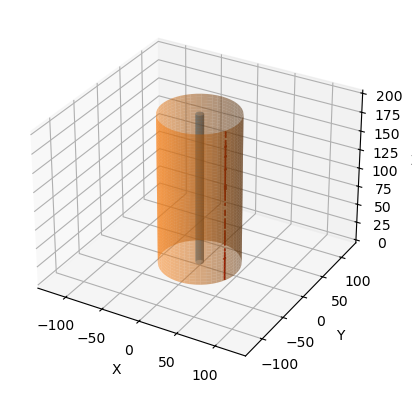

In [101]:
plot_state(Rs_sol[-1, :, :])

In [102]:
pss, Rss, t = solver(5, 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [103]:
save_output(t, Rss, pss, N, 5)

In [104]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)

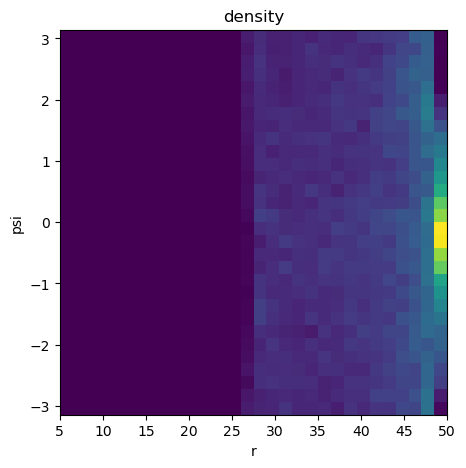

In [105]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(r, psi, bins = 30, range = [[R1, R2], [-np.pi, np.pi]])
axs.set_xlabel('r')
axs.set_ylabel('psi')
axs.set_title('density')
plt.show()

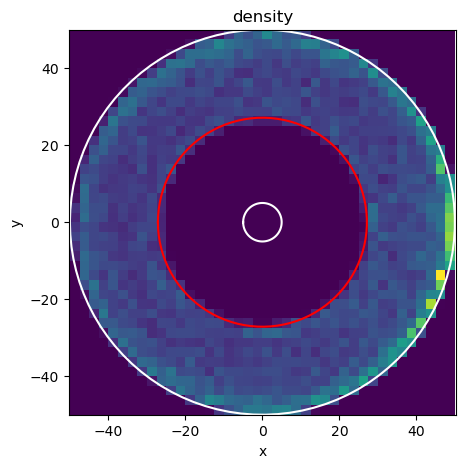

In [106]:
fig, axs = plt.subplots(figsize = (5,5))
axs.hist2d(coords[:, 0], coords[:, 1], bins = 40, range = [[-R2, R2], [-R2, R2]])
axs.axis('equal')
axs.set_xlabel('x')
axs.set_ylabel('y')
axs.set_title('density')

R_dep = scipy.optimize.fsolve(V, R1, args = 5, xtol=1e-06, maxfev=500)
angle = np.linspace(-np.pi, np.pi, 100)
axs.plot(R1 * np.cos(angle), R1 * np.sin(angle), color = 'white')
axs.plot(R2 * np.cos(angle), R2 * np.sin(angle), color = 'white')
axs.plot(R_dep[0] * np.cos(angle), R_dep[0] * np.sin(angle), color = 'red')
#plt.colorbar()
plt.show()

In [107]:
steady = Rss[-40000:-1:100, :, :]
coords = steady.reshape((40000,3))
#coords = Rss[-1, :, :]
#vs = (Rss[-1, :, :] - Rss[-2, :, :]) / 0.1
steady1 = Rss[-40001:-2:100, :, :]
vs = (steady - steady1) / 0.1
vs = vs.reshape((40000,3))
psi = np.arctan2(coords[:, 1], coords[:, 0])
alpha = np.arctan2(vs[:, 1], vs[:, 0])
r = np.linalg.norm(coords[:, :2], axis = 1)
v = np.linalg.norm(vs[:, :2], axis = 1)
v_r = v * np.cos(psi - alpha)
v_phi = v * np.sin(psi - alpha)

In [108]:
steady_p = pss[-40000:-1:100, :, :]
coords_p = steady.reshape((40000,3))
phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
delta = psi-phi

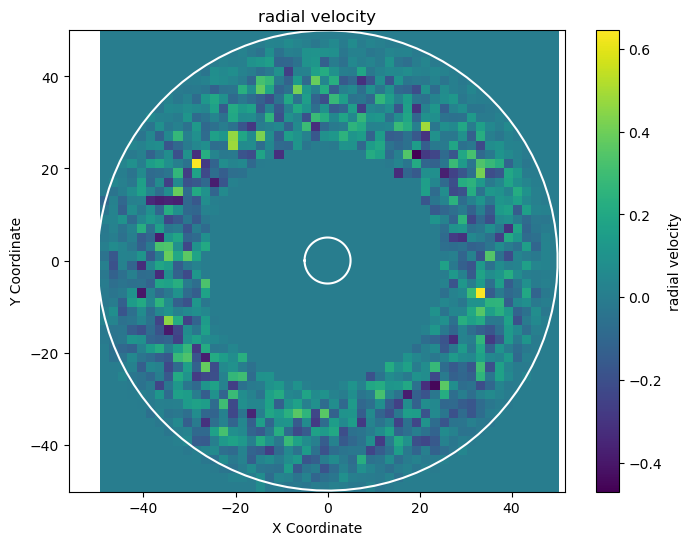

In [109]:
plot_function(coords[:,:2], v_r, grid_size = 50, custom_name = "radial velocity")

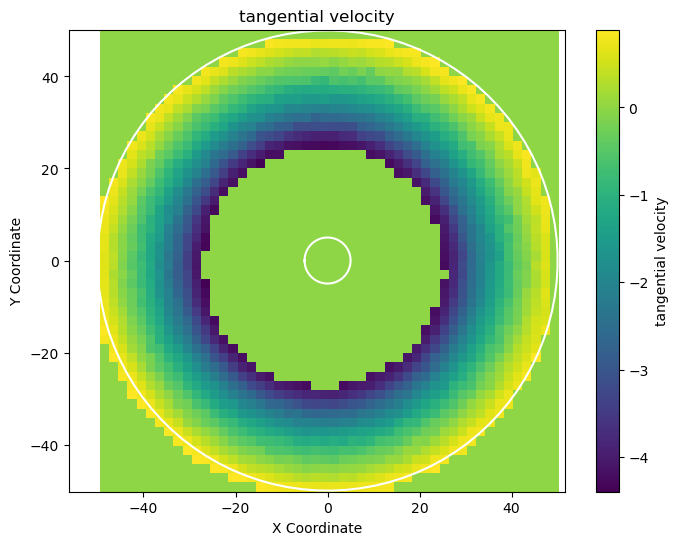

In [110]:
plot_function(coords[:,:2], v_phi, grid_size = 50, custom_name = "tangential velocity")

In [111]:
ps1, Rs1, t = solver(0.5, 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

Tumbling period: 1431.7881813614306
omega/D_R: 153.30076873028807


In [112]:


steady1 = Rs1[-40000:-1:100, :, :]
coords1 = steady1.reshape((40000,3))
psi = np.arctan2(coords1[:, 1], coords1[:, 0])
steady_p = ps1[-40000:-1:100, :, :]
coords_p = steady_p.reshape((40000,3))
phi = np.arctan2(coords_p[:, 1], coords_p[:, 0])
delta = (psi-phi)%(2*np.pi)


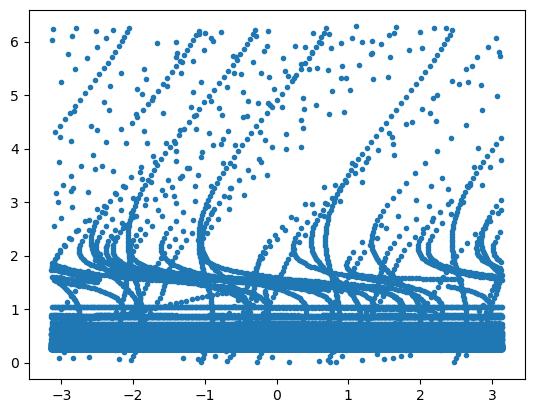

In [113]:
plt.plot(psi, delta, '.')

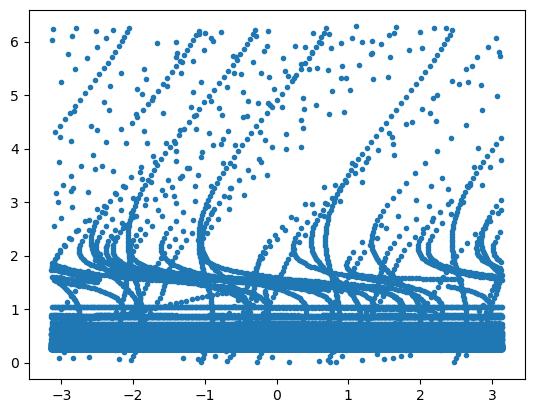

In [114]:
plt.plot(psi, delta, '.')

In [115]:
ps2, Rs2, t = solver(0.2, 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)

No tumbling
omega/D_R: 61.32030749211523


In [116]:
save_output(t, Rs2, ps2, N, 0.2, custom_name = "Omega0.2")

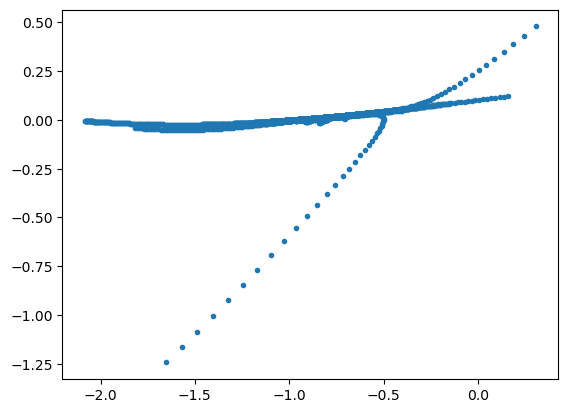

In [117]:

steady2 = Rs2[-40000:-1:100, :, :]
coords2 = steady2.reshape((40000,3))
psi2 = np.arctan2(coords2[:, 1], coords2[:, 0])
steady_p2 = ps2[-40000:-1:100, :, :]
coords_p2 = steady_p2.reshape((40000,3))
phi2 = np.arctan2(coords_p2[:, 1], coords_p2[:, 0])
delta2 = (psi2-phi2)
plt.plot(psi2, delta2, '.')

### Test run high epsilon

In [118]:
pss_e, Rss_e, t = solver(3, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = False)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [119]:
save_output(t, Rss_e, pss_e, N, 5, custom_name="epsilon10", skip = 100, num = 100000)

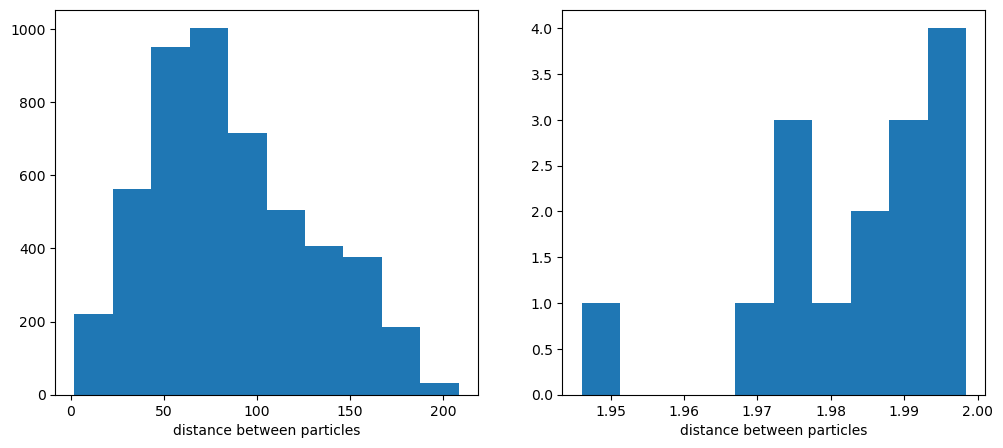

In [120]:
plot_dist(Rss_e, N, 2, 10)

In [121]:
from scipy.cluster.hierarchy import fclusterdata
clust = np.sort(fclusterdata(Rss_e[-1, :, :], t=3, criterion='distance'))
num = clust[-1]
print(clust)

[ 1  1  2  3  4  5  6  7  8  9 10 11 11 12 12 13 13 13 14 14 15 15 16 17
 17 17 17 18 18 18 19 19 20 20 21 22 23 24 25 26 27 27 28 29 30 30 31 32
 33 34 35 35 35 35 35 35 35 35 35 35 35 35 36 37 38 38 39 39 39 39 40 41
 42 43 44 45 46 47 48 48 49 50 51 52 53 53 54 55 56 56 57 58 59 60 60 61
 62 63 64 65]


In [122]:
clust_num = 0
for i in range(0, 100, 10):
    clust = np.sort(fclusterdata(Rss_e[-1 - i, :, :], t=3, criterion='distance'))
    clust_num += clust[-1]
clust_num = clust_num // 10
print(clust_num)

65


In [123]:
from collections import Counter 
 
def max_repetitions(sequence): 
    # Count the occurrences of each element 
    counts = Counter(sequence) 
    # Get the maximum count 
    max_count = max(counts.values()) 
    return max_count 

def average_size(sequence):
    counts = Counter(sequence)
    return sum(counts.values()) / len(counts.values())
# Example usage 
sequence = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4] 
result = max_repetitions(sequence) 
print(f"The maximum number of repetitions is: {result}") 

The maximum number of repetitions is: 4


In [124]:
average_size(clust)

1.5151515151515151

In [125]:
max_repetitions(clust) 

12

In [126]:
pss_e, Rss_e, t = solver(3, 100, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [127]:
save_output(t, Rss_e, pss_e, N, 5, custom_name="epsilon100", skip = 100, num = 100000)

In [128]:
ps_e50, Rs_e50, t50 = solver(3, 50, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [129]:
def get_cluster_data(Rs):
    sizes = []
    for i in range(0, len(Rs), 10):
        clust = np.sort(fclusterdata(Rs[i, :, :], t=2, criterion='distance'))
        sizes.append(average_size(clust))
    return sizes

In [130]:
sizes = get_cluster_data(Rs_e50)

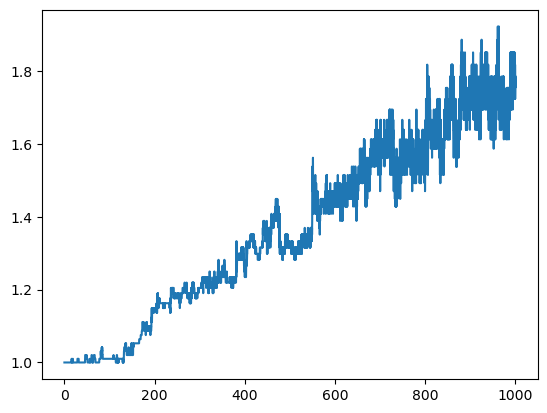

In [131]:
plt.plot(t50[::10], sizes)

In [132]:
window_size = 20
moving_avg = np.convolve(sizes, np.ones(window_size)/window_size, mode='same')

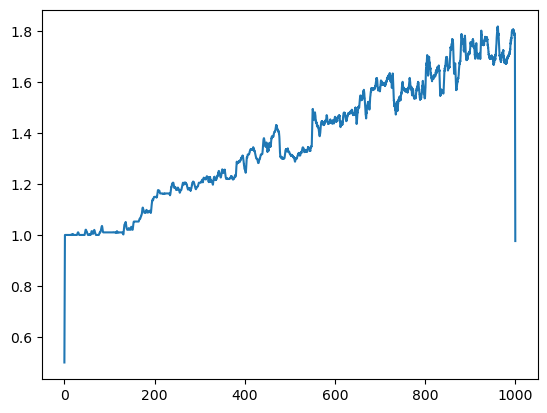

In [133]:
plt.plot(t50[::10], moving_avg)

### Radius test

In [134]:
def V(R, Omega):
    B = Omega * R2 ** 2 / (R2 ** 2 / R1 ** 2 - 1)
    return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))

In [135]:
import scipy
r_dep = scipy.optimize.fsolve(V, R1, args = 3, xtol=1e-06, maxfev=500)
print(r_dep[0])

19.878311982057344


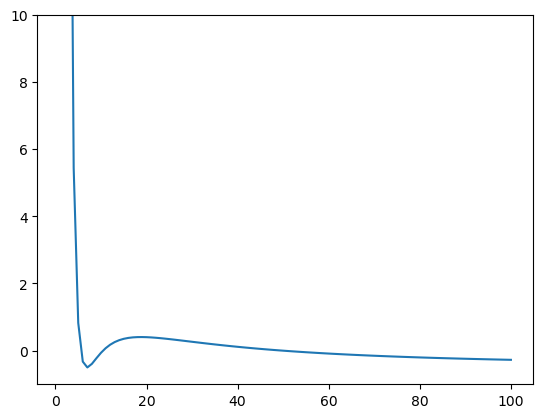

In [136]:
x = np.linspace(1, 100, 100)
plt.ylim(top = 10, bottom = -1)
plt.plot(x, V(x, 1))

# Scan

## Without gravity

In [137]:
Omegas = np.linspace(0., 1., 10)
R = []
p = []
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_46463/3374552208.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_46463/3374552208.py:3: RuntimeWarning: invalid value encountered in multiply
  return(0.5  * (B ** 2/ R ** 2 * (np.log(R2/R) - v0/B * R2) ** 2 - v0 ** 2))
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_46463/3893087886.py:15: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  R_dep = scipy.optimize.fsolve(V, R1, args = Omegas[i], xtol=1e-06, maxfev=500)


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

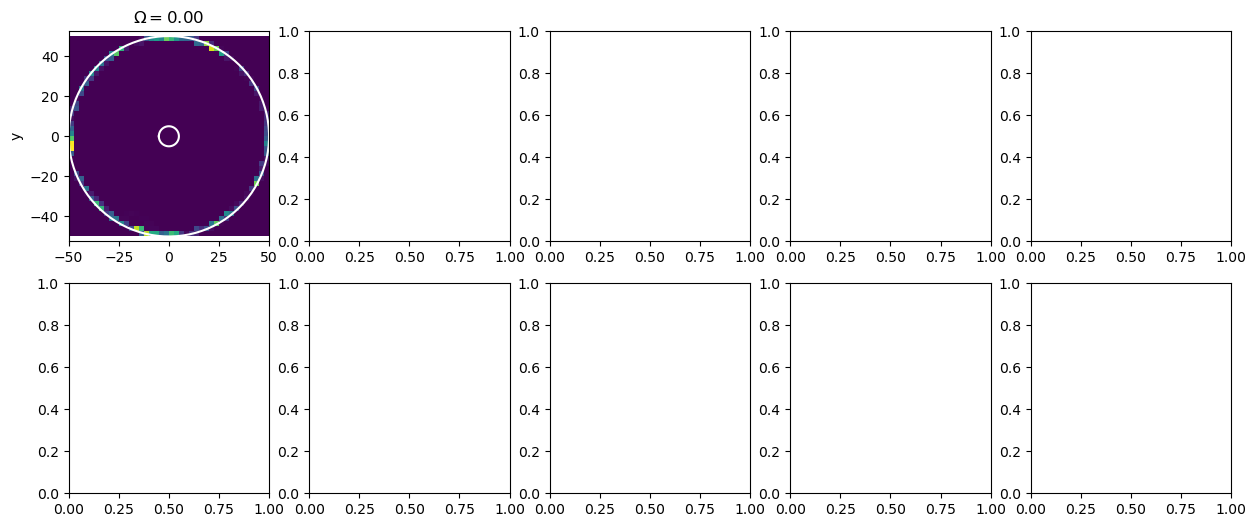

In [138]:
plot_density(R, Omegas)

In [ ]:
plot_velocity(R, Omegas)

In [ ]:
plot_delta(R, p, Omegas)

In [139]:
Omegas1 = np.linspace(1., 10., 10)
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


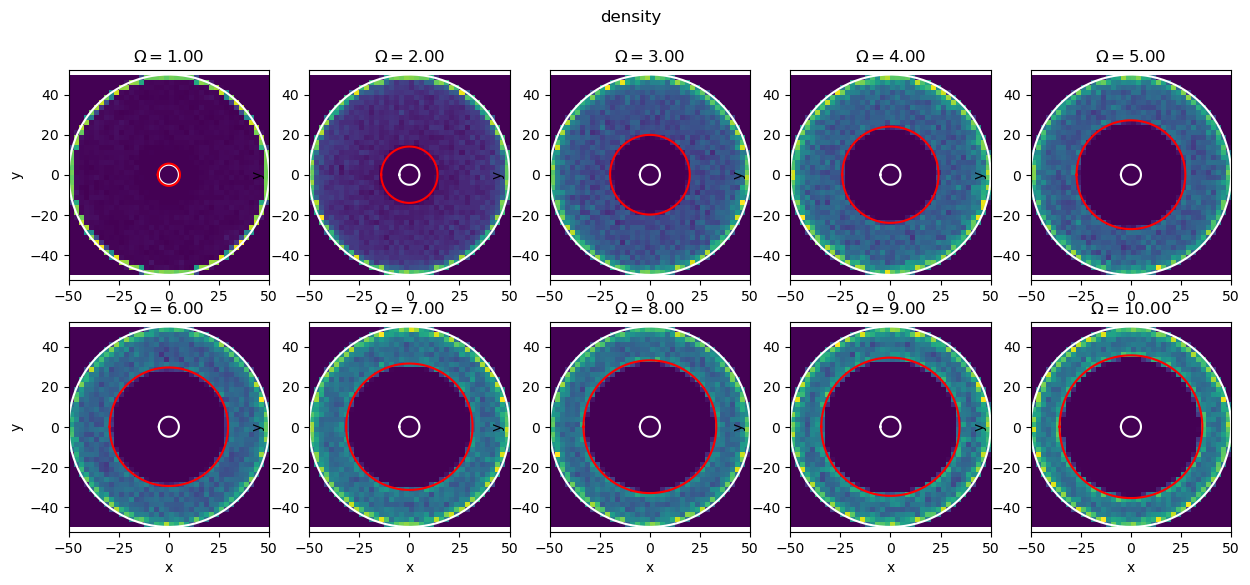

In [143]:
plot_density(R, Omegas1, depletion = True)

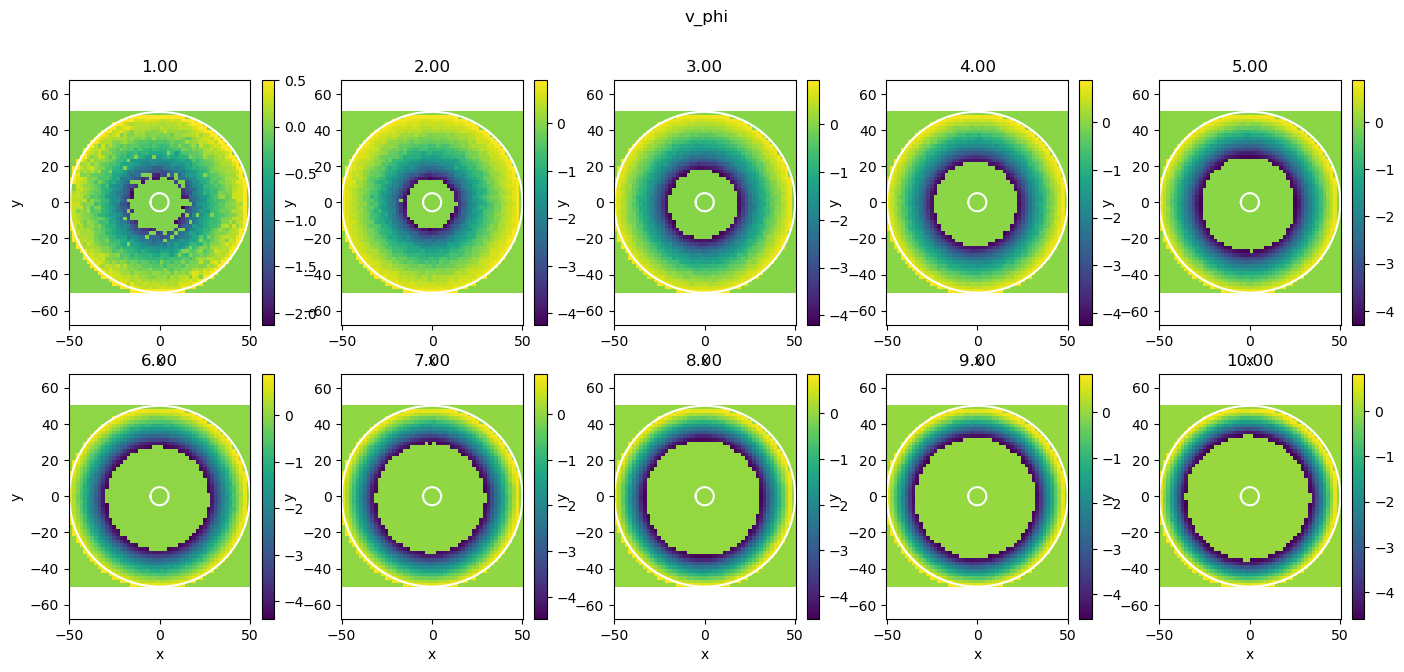

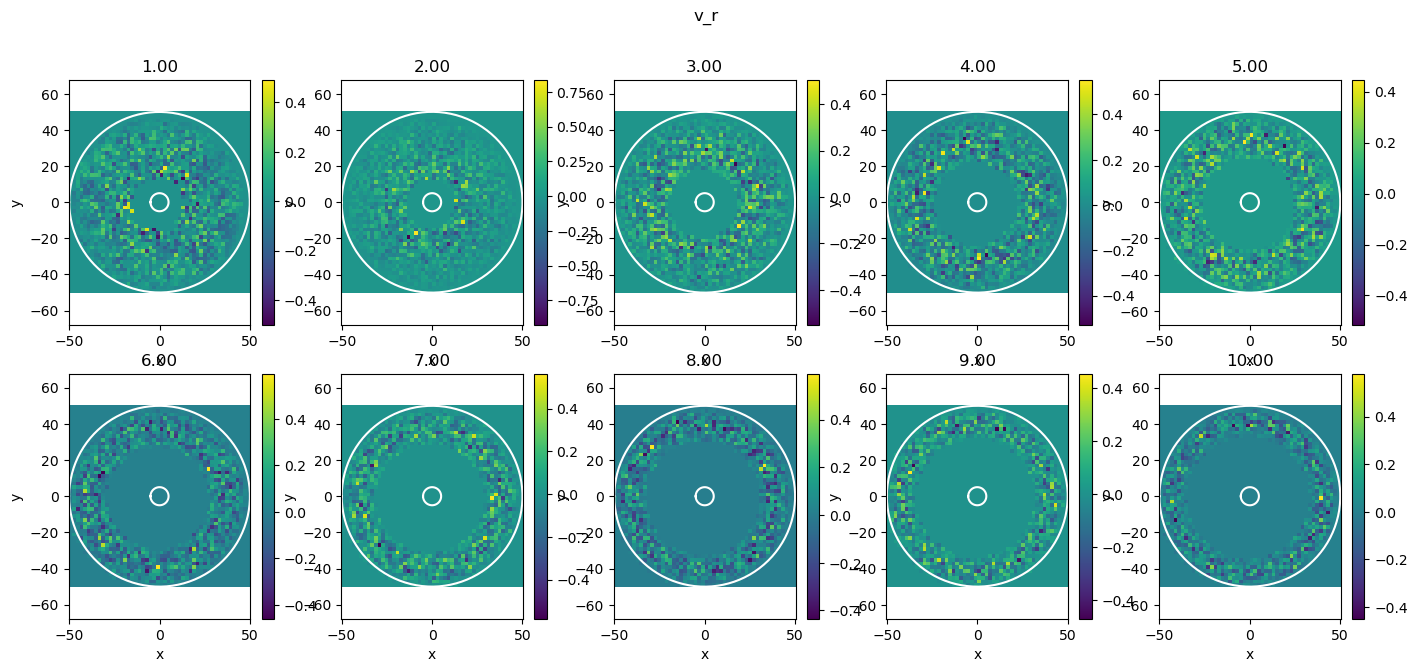

In [49]:
plot_velocity(R, Omegas1)

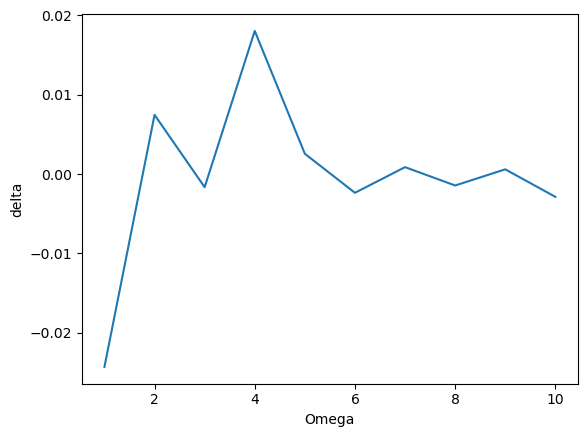

In [50]:
plot_delta(R, p, Omegas1)

### Without noise


In [51]:
Omegas1 = np.linspace(1., 10., 10)
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, k0, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = False)
    R.append(Rs)
    p.append(ps)
    

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


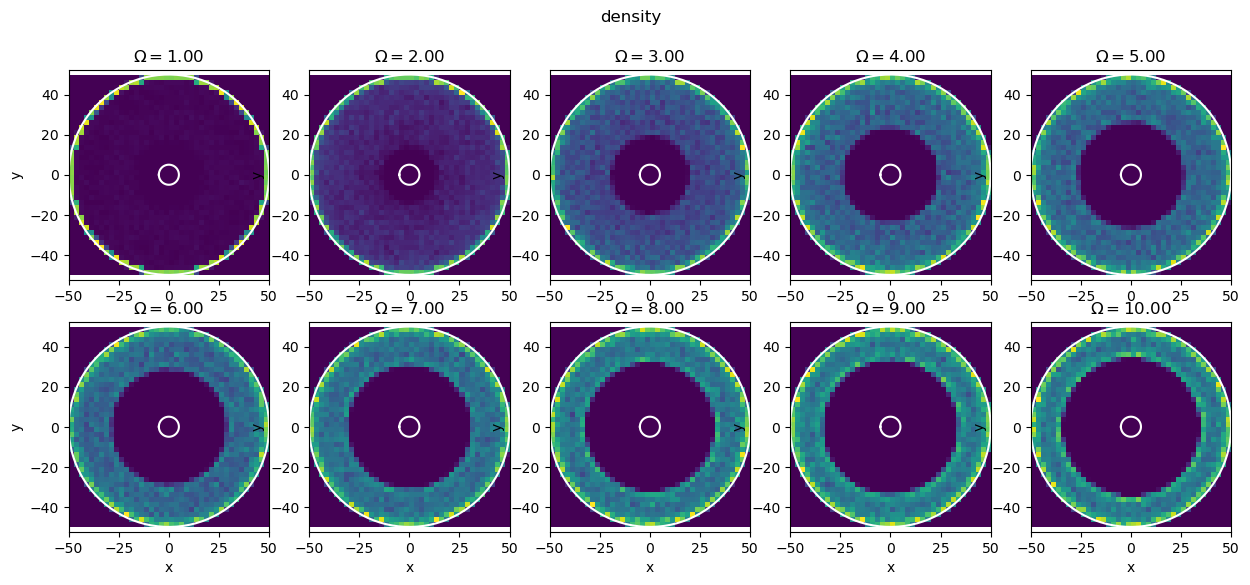

In [52]:
plot_density(R, Omegas1)

## With gravity

In [44]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)
    

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


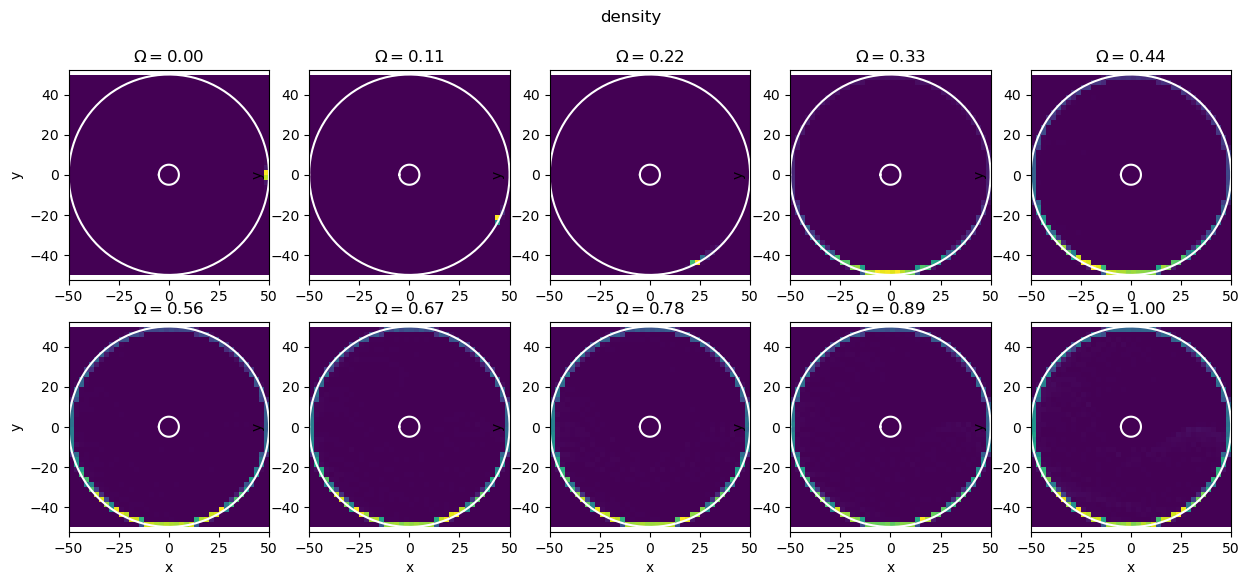

In [45]:
plot_density(R, Omegas)

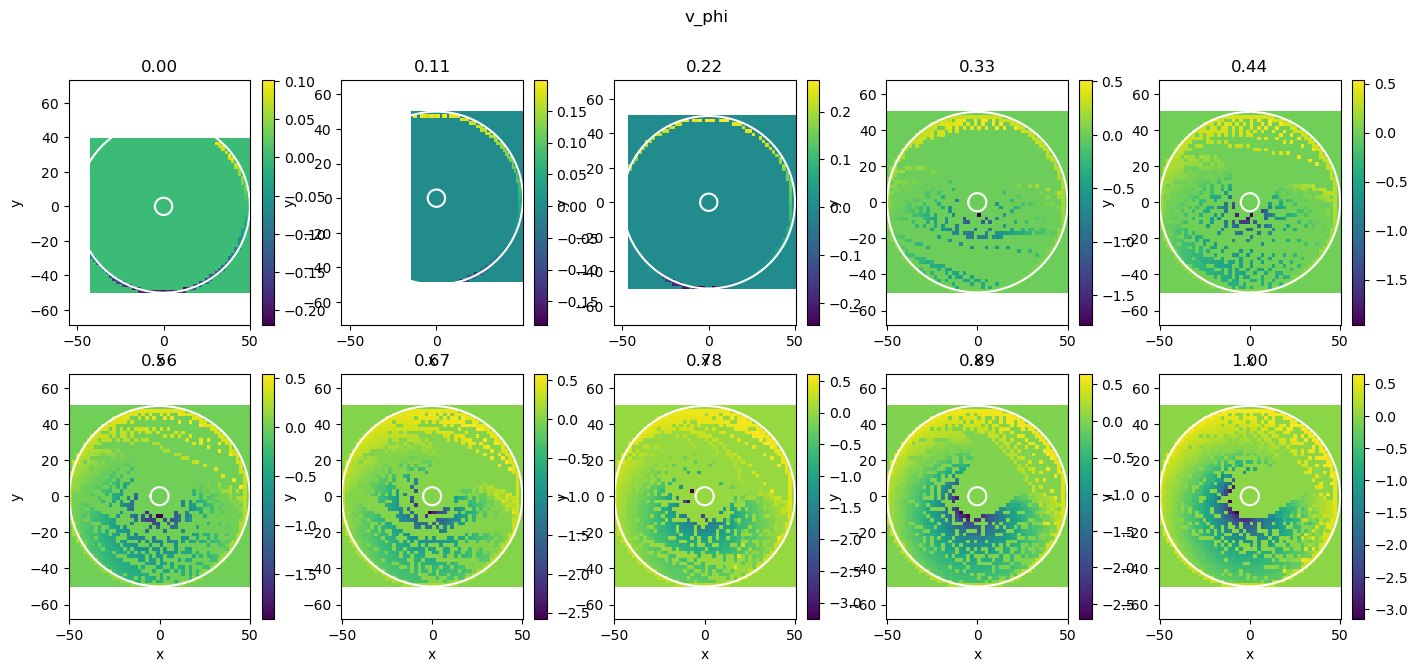

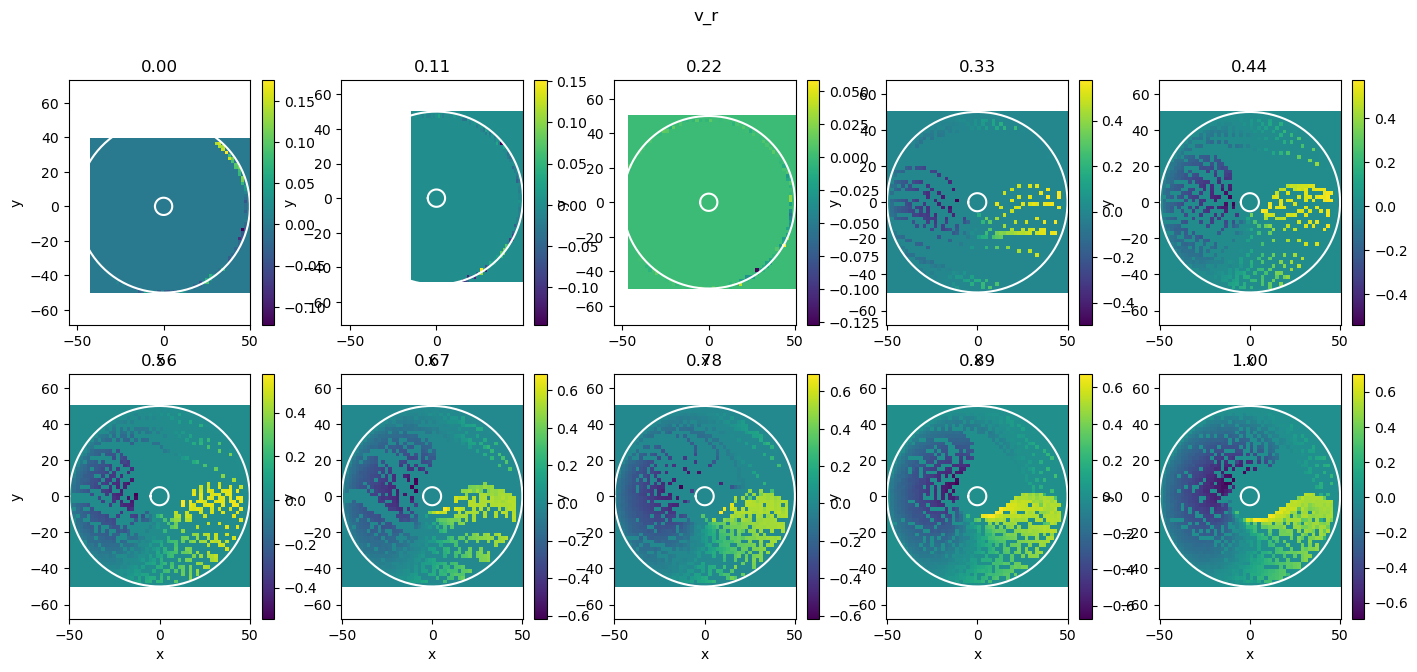

In [46]:
plot_velocity(R, Omegas)

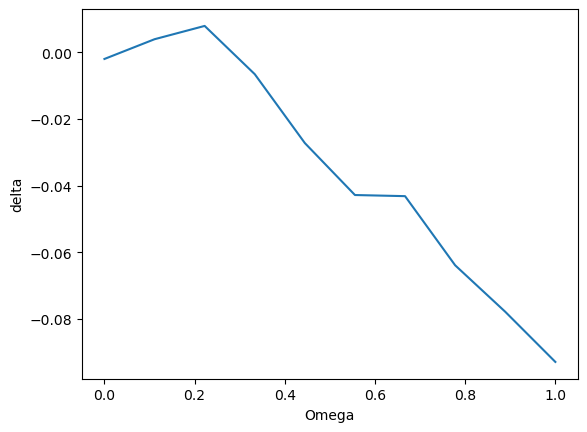

In [47]:
plot_delta(R, p, Omegas)

In [48]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0.01, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


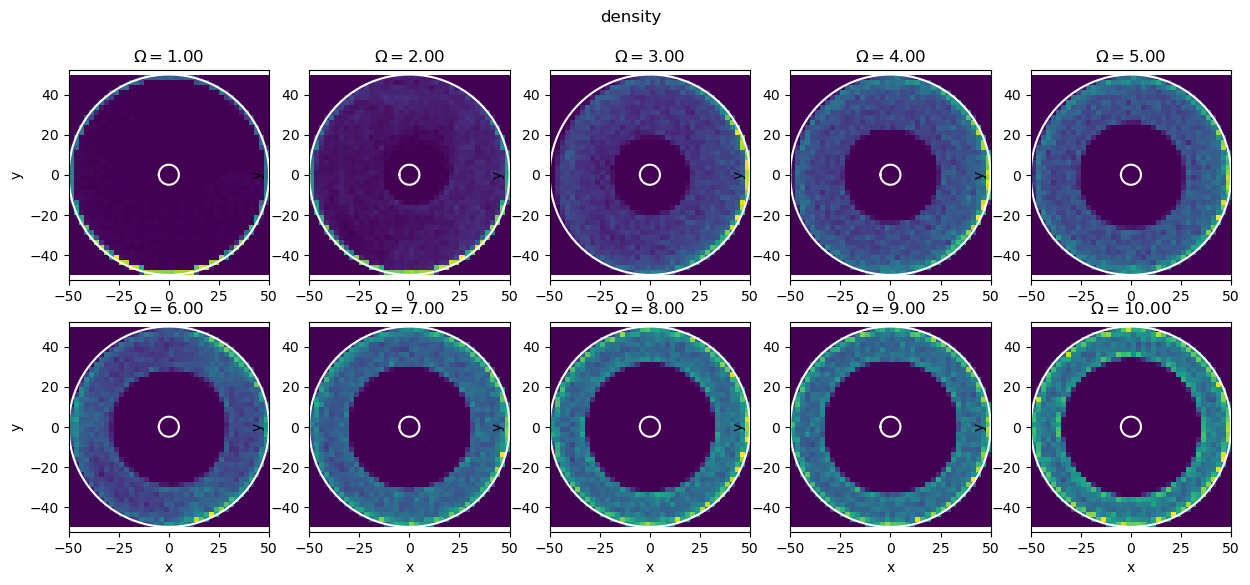

In [49]:
plot_density(R, Omegas1)

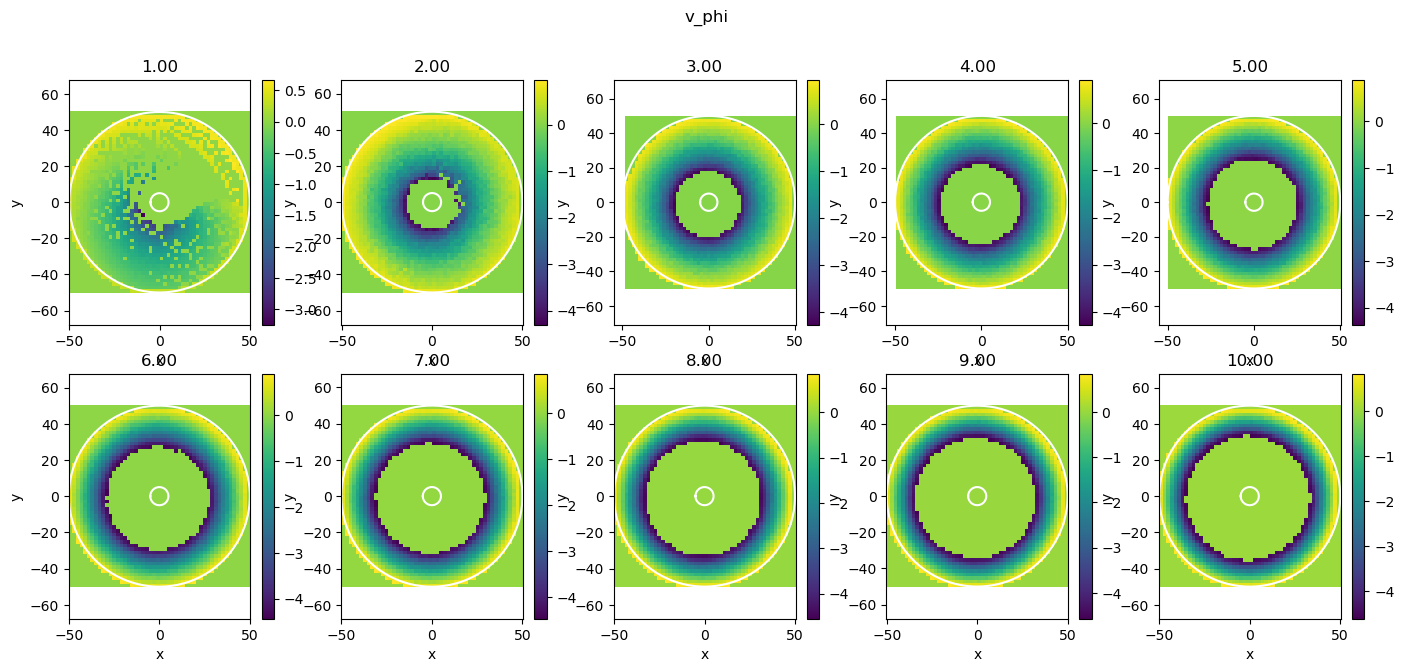

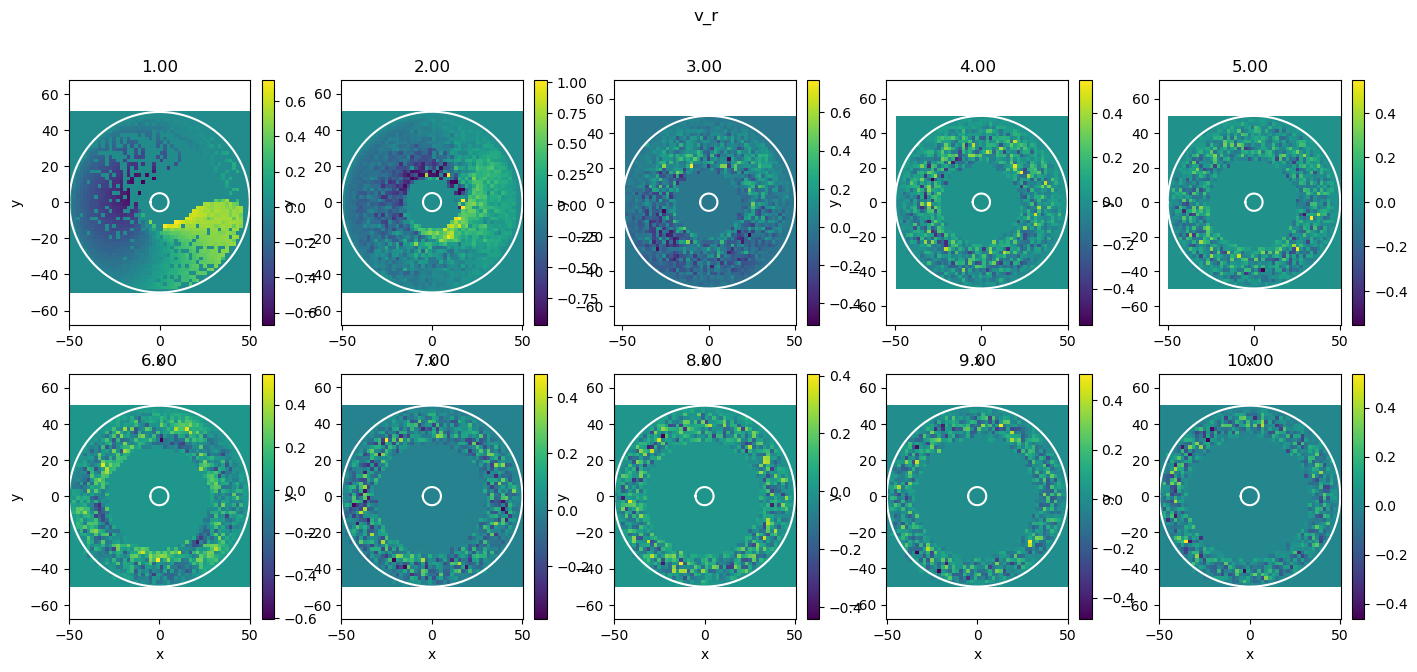

In [50]:
plot_velocity(R, Omegas1)

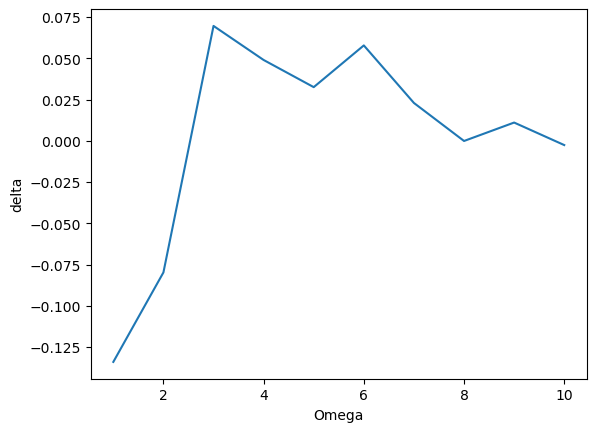

In [51]:
plot_delta(R, p, Omegas1)

## Without interaction

In [52]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


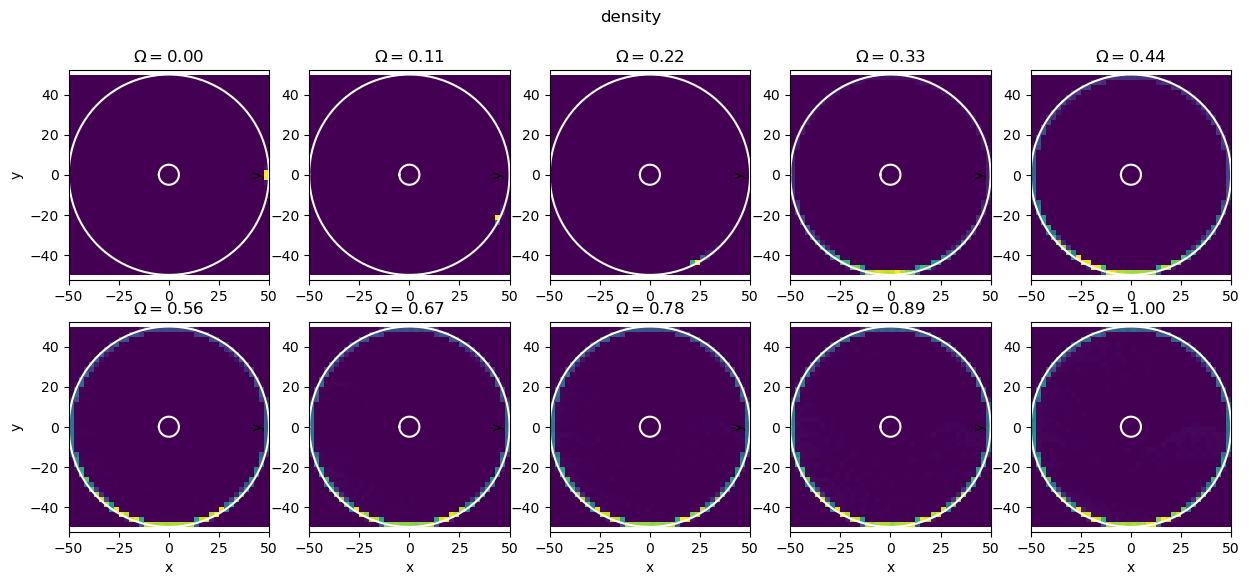

In [53]:
plot_density(R, Omegas)

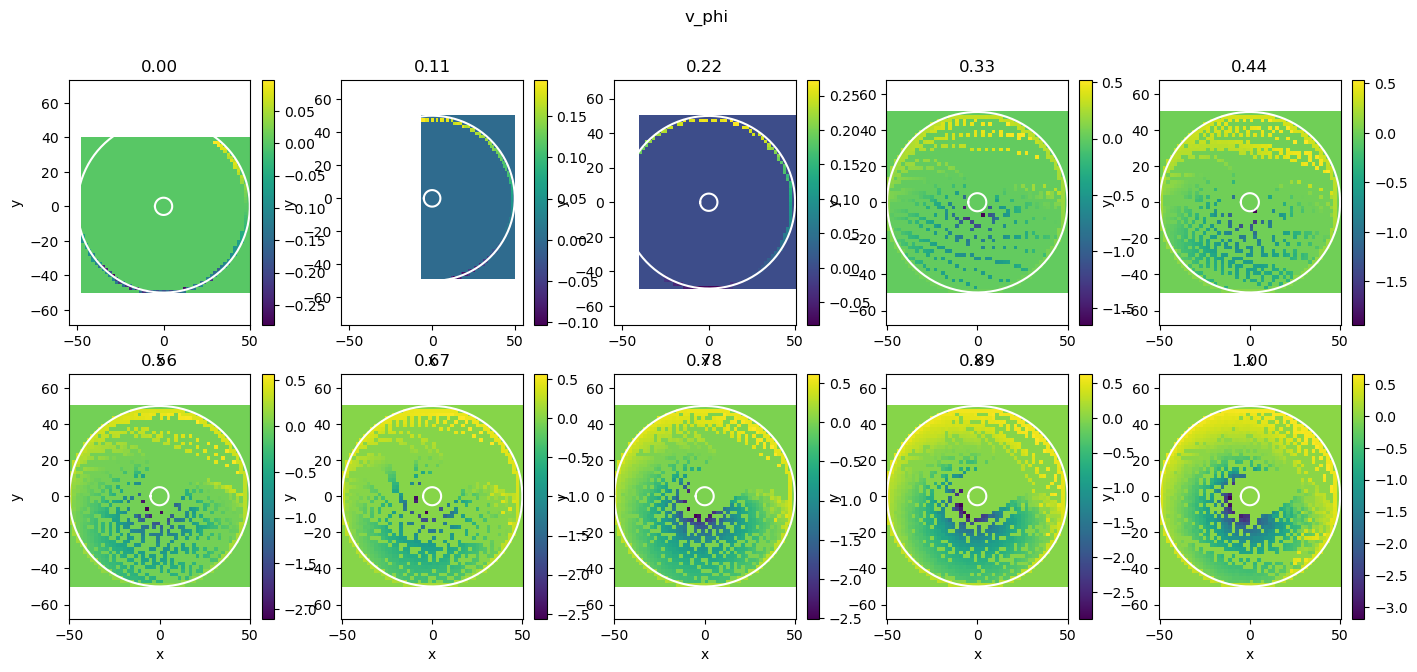

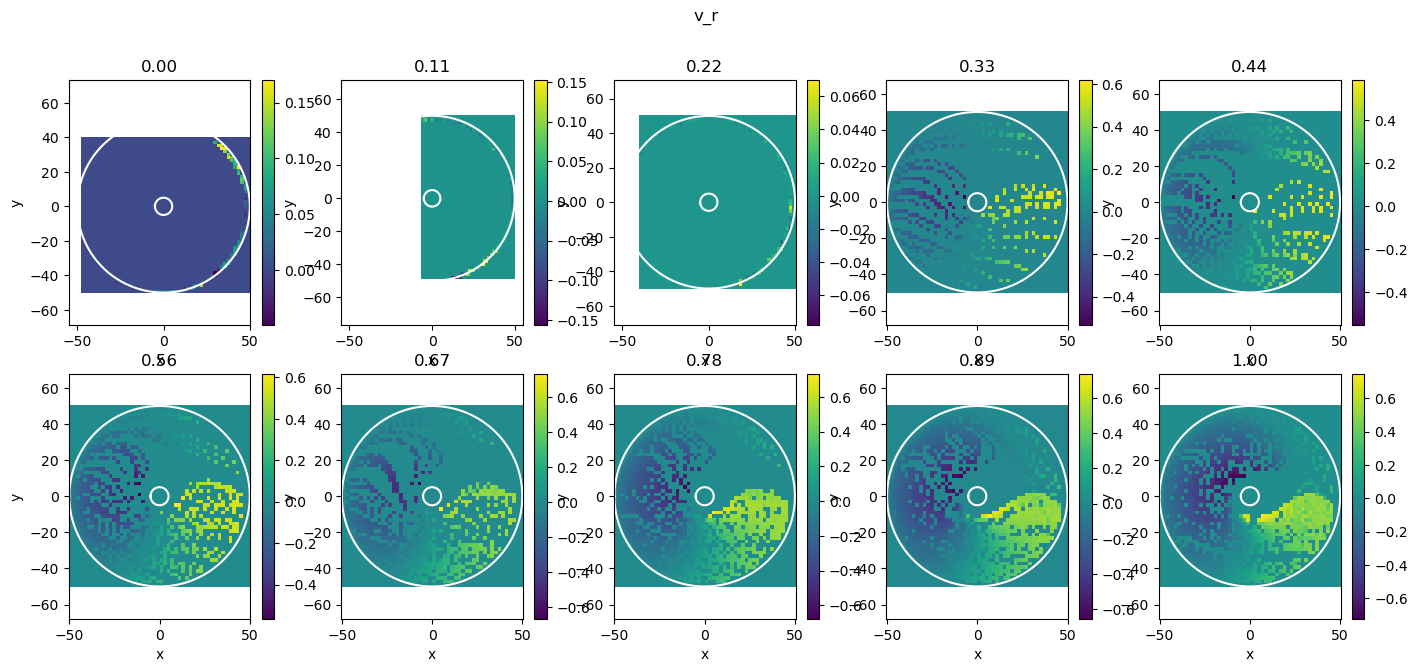

In [54]:
plot_velocity(R, Omegas)

In [55]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 0, kx, euler, N, np.array(p0s), np.array(R0s), 0.1, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


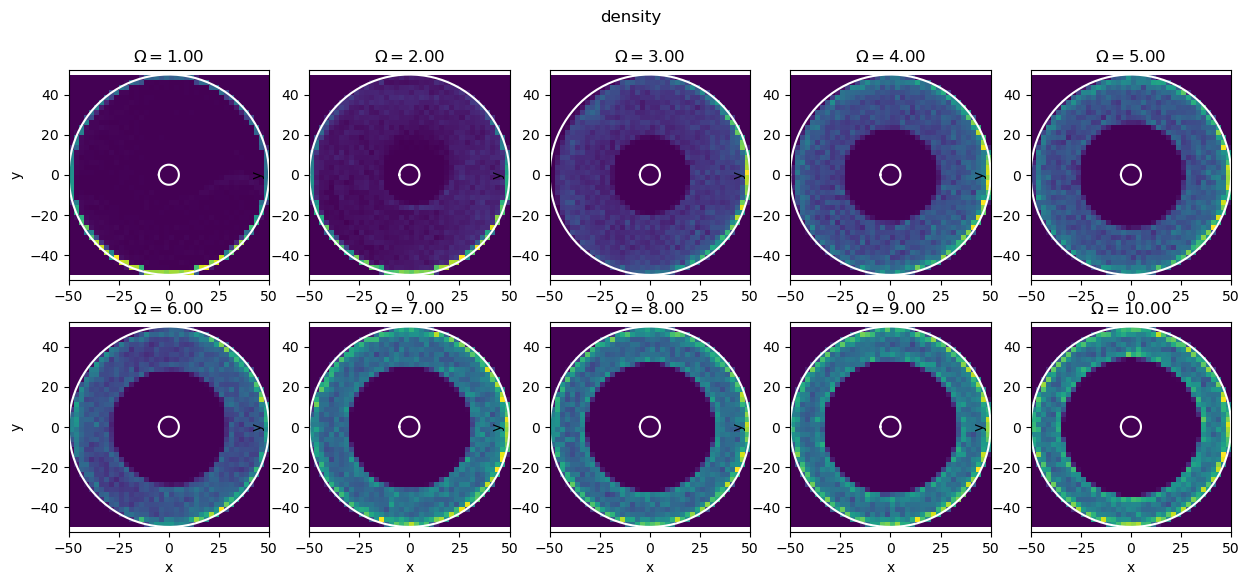

In [56]:
plot_density(R, Omegas1)

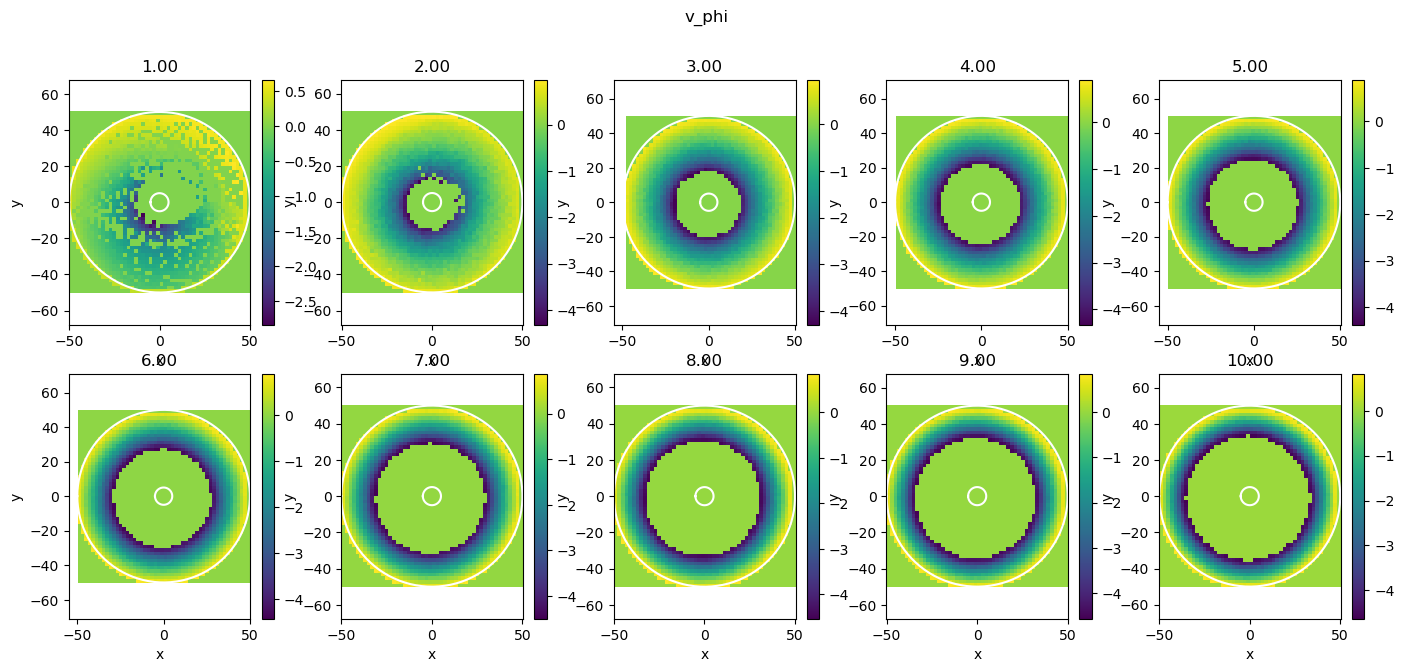

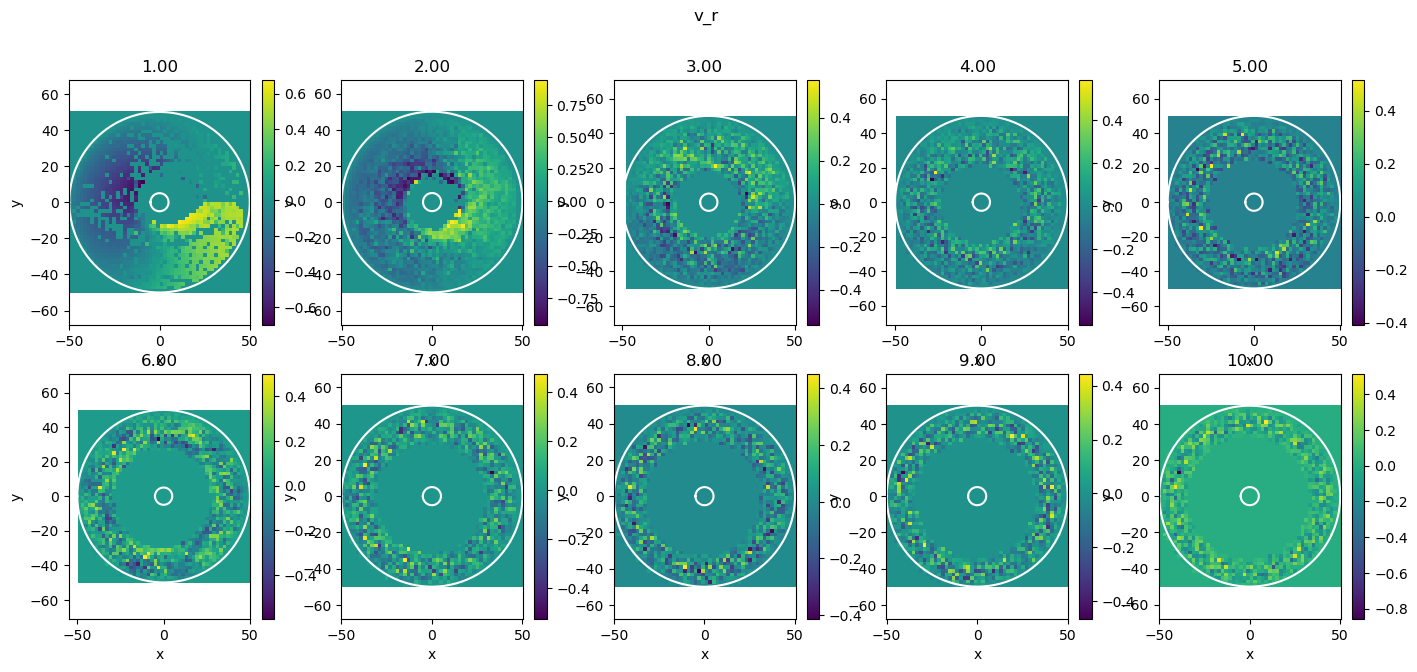

In [57]:
plot_velocity(R, Omegas1)

## With interaction

### $\varepsilon = 50$

In [58]:
ps, Rs, t = solver(3, 50, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)

Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [59]:
save_output(t, Rs, ps, N, 1, custom_name = "epsilon50_long", skip = 100, num = 500000)

### $\varepsilon = 10$

In [60]:
ps, Rs, t = solver(1, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)

Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


In [61]:
save_output(t, Rs, ps, N, 0.5, custom_name = "epsilon10_Omega1", skip = 100, num = 500000)

In [62]:
ps, Rs, t = solver(5, 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)

Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806


In [63]:
save_output(t, Rs, ps, N, 0.5, custom_name = "epsilon10_Omega5")

In [64]:
R.clear()
p.clear()
for i in range(len(Omegas)):
    print(i)
    ps, Rs, t = solver(Omegas[i], 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
No tumbling
omega/D_R: 0.0
1
No tumbling
omega/D_R: 34.066837495619566
2
No tumbling
omega/D_R: 68.13367499123913
3
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
4
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
5
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
6
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
7
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
8
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


In [65]:
save_output(t, R[-1], p[-1], N, Omegas[-1], custom_name = "epsilon10_Omega1")

No tumbling
omega/D_R: 0.0
No tumbling
omega/D_R: 34.066837495619566
No tumbling
omega/D_R: 68.13367499123913
Tumbling period: 2785.872957076454
omega/D_R: 102.2005124868587
Tumbling period: 1685.0297865213895
omega/D_R: 136.26734998247827
Tumbling period: 1250.626839629185
omega/D_R: 170.33418747809787
Tumbling period: 1004.8679683961309
omega/D_R: 204.4010249737174
Tumbling period: 843.6116662298275
omega/D_R: 238.46786246933695
Tumbling period: 728.6028362790004
omega/D_R: 272.53469996495653
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


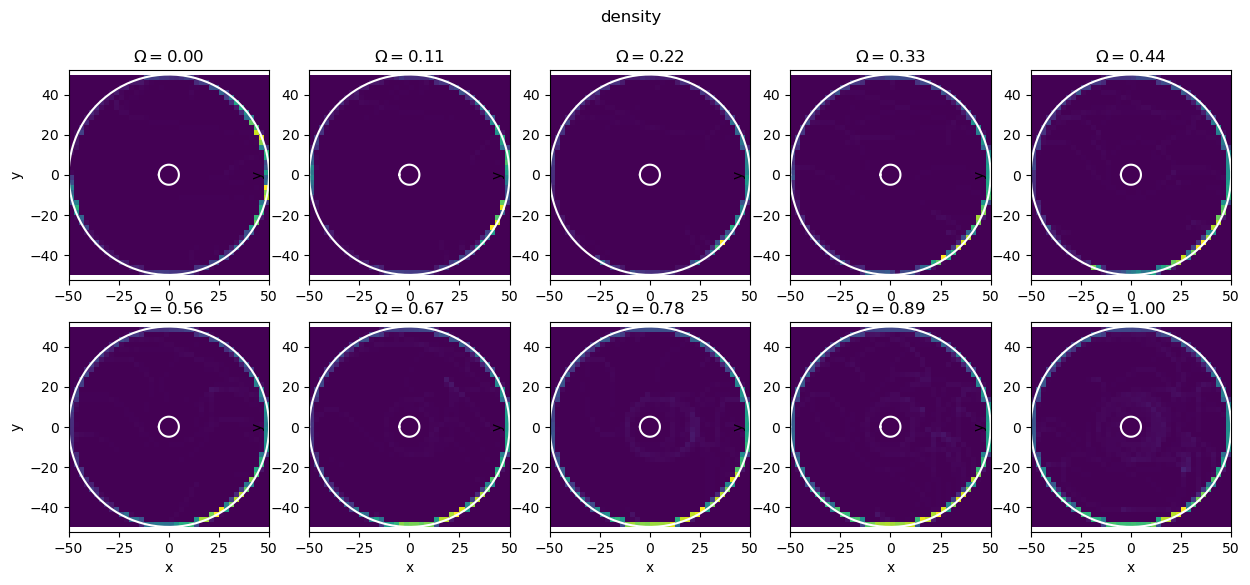

In [66]:
plot_density(R, Omegas)

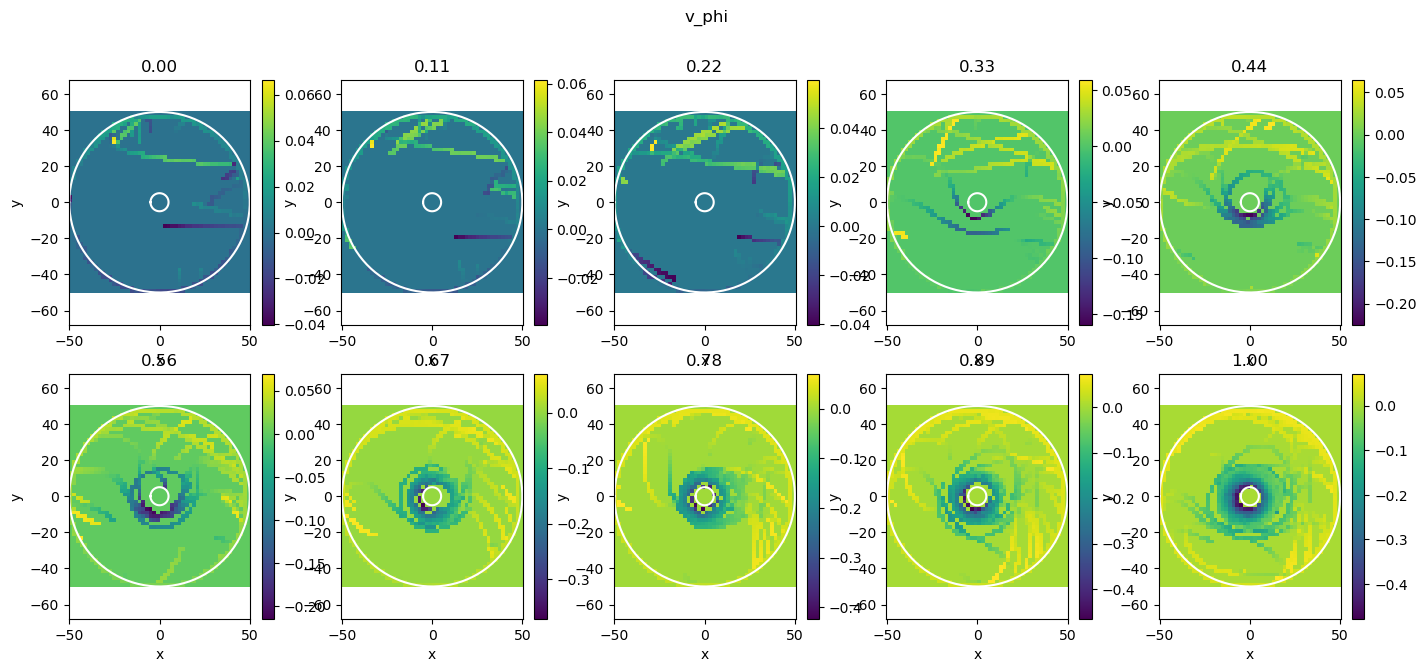

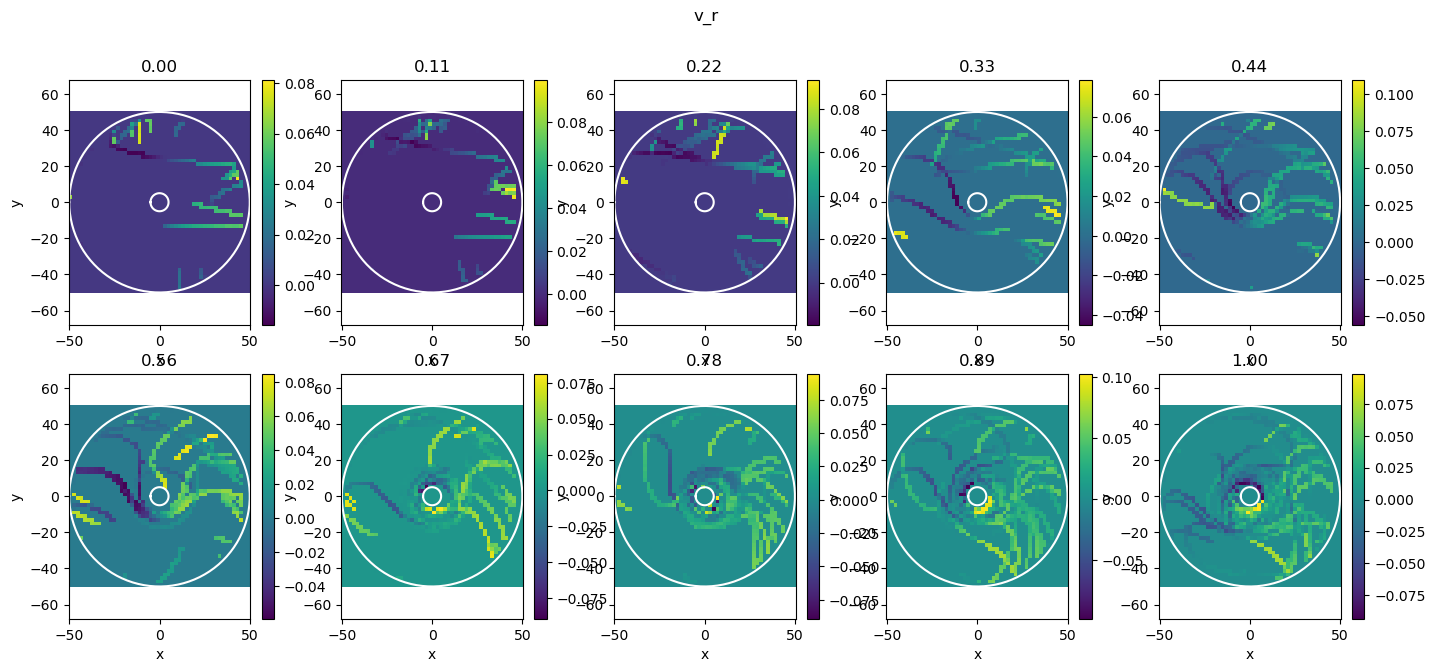

In [67]:
plot_velocity(R, Omegas)

In [68]:
R.clear()
p.clear()
for i in range(len(Omegas1)):
    print(i)
    ps, Rs, t = solver(Omegas1[i], 10, kx, euler, N, np.array(p0s), np.array(R0s), 0.01, 50000, noise = True)
    R.append(Rs)
    p.append(ps)

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
4
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
5
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
6
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
7
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
8
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
9
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
Tumbling period: 313.4268510611466
omega/D_R: 613.2030749211523
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
Tumbling period: 155.8073778597314
omega/D_R: 1226.4061498423046
Tumbling period: 124.55976395549156
omega/D_R: 1533.0076873028806
Tumbling period: 103.76087295819339
omega/D_R: 1839.6092247634567
Tumbling period: 88.91778887152803
omega/D_R: 2146.210762224033
Tumbling period: 77.79165540971741
omega/D_R: 2452.812299684609
Tumbling period: 69.14118733515862
omega/D_R: 2759.413837145185
Tumbling period: 62.222595074664795
omega/D_R: 3066.0153746057613


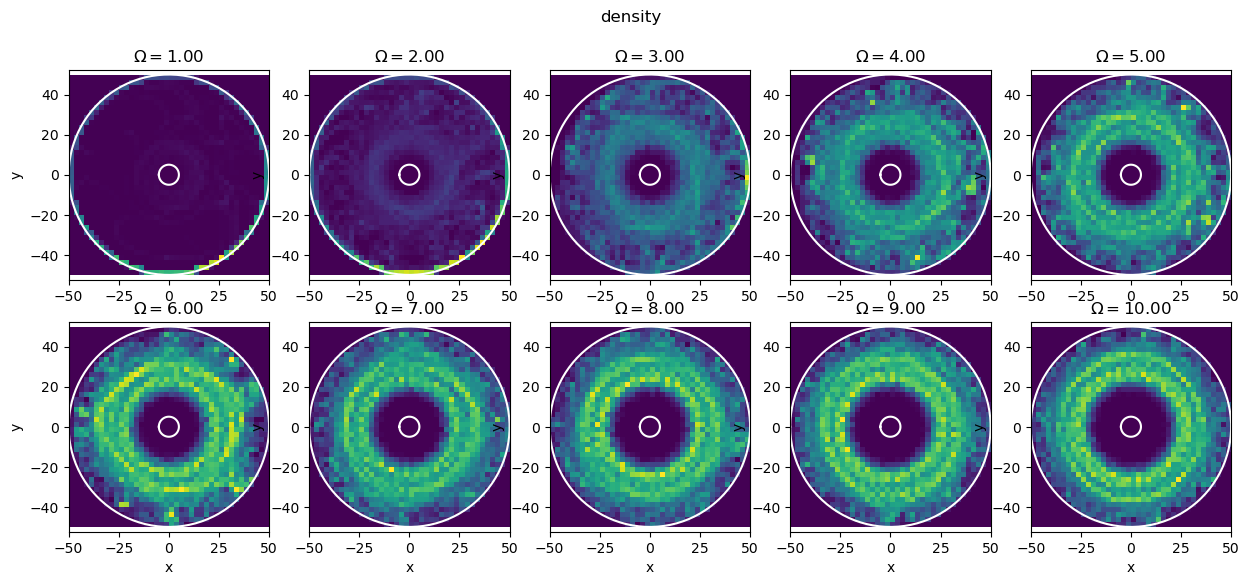

In [69]:
plot_density(R, Omegas1)

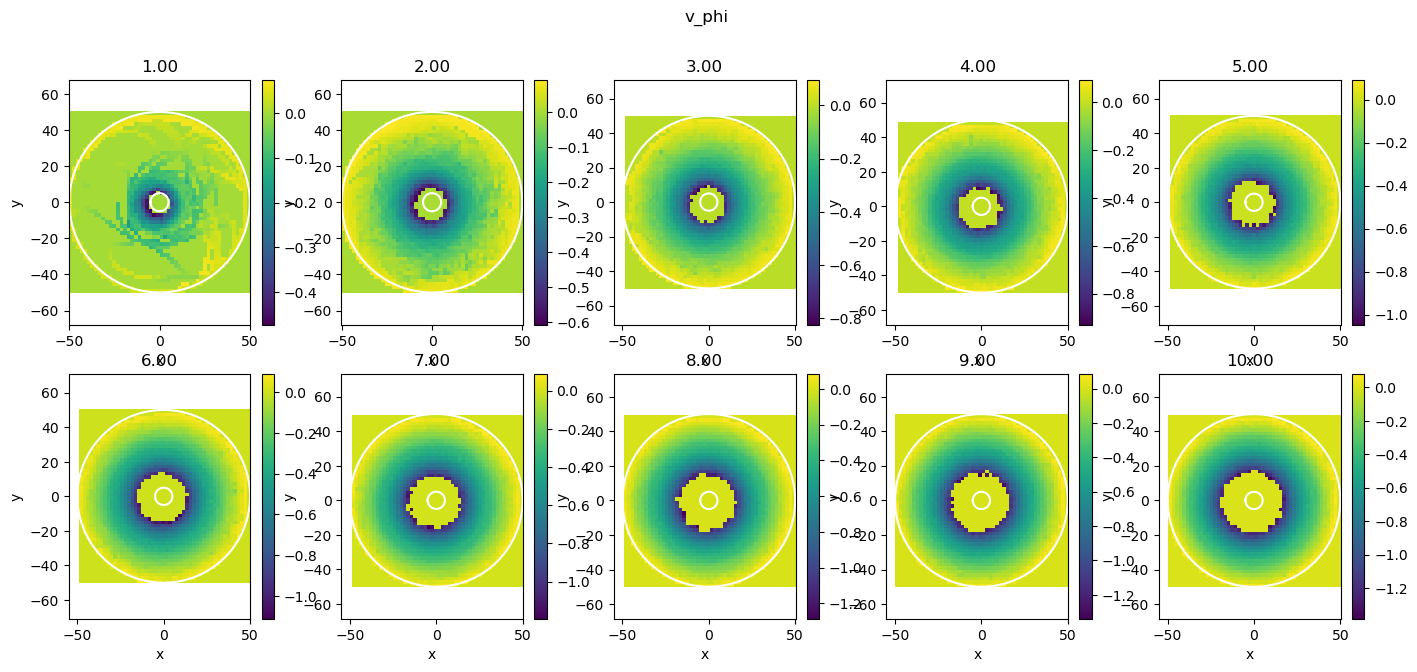

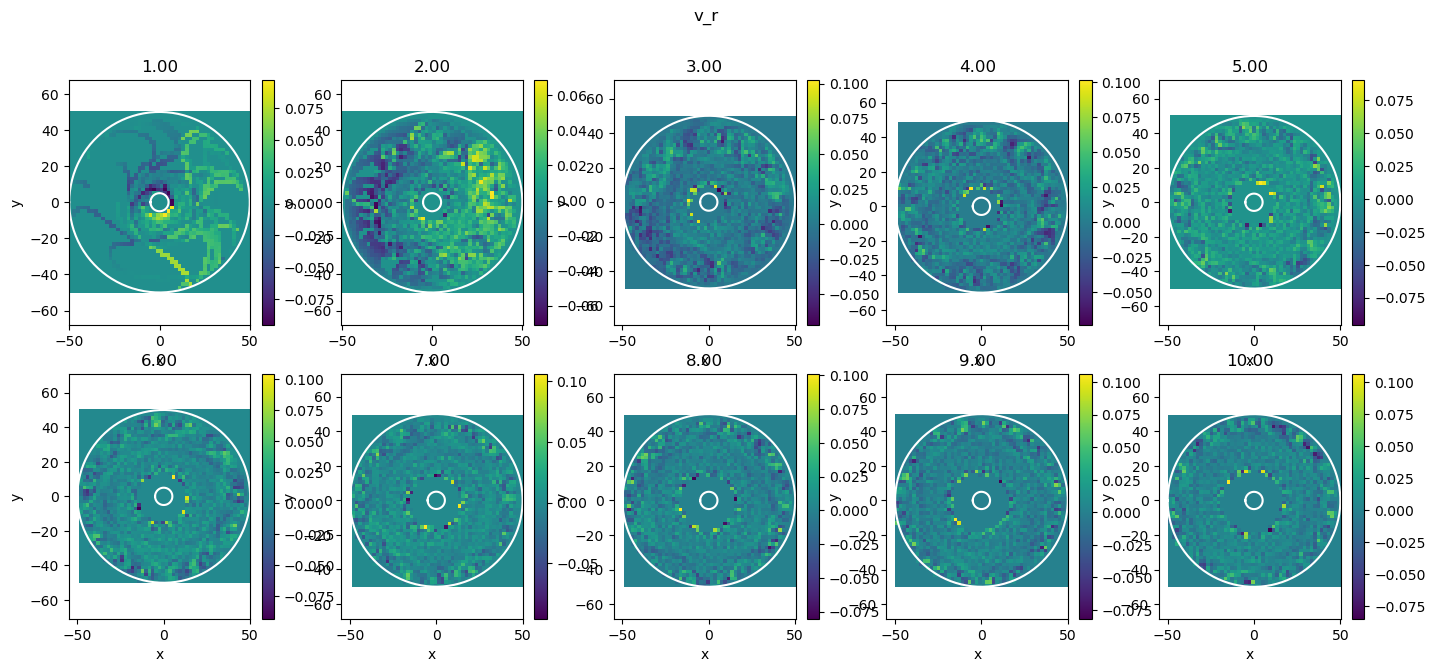

In [70]:
plot_velocity(R, Omegas1)

## Clustering

### $0<\varepsilon<50$

In [100]:
sizes = []

In [101]:
R.clear()
p.clear()
sizes.clear()
epsilons = np.linspace(1., 50., 10)
for i in range(len(epsilons)):
    print(i)
    ps, Rs, t = solver(3, epsilons[i], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    R.append(Rs)
    p.append(ps)

    

0
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
1
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
4
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
5
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
6
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
7
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
8
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
9
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284


In [40]:
save_output(t, R[-1], p[-1], N, 5, custom_name="epsilon50", skip = 100, num = 100000)

In [102]:
nums = []
max_sizes = []
av_sizes = []
for j in range(len(epsilons)):
    clust_num = 0
    clust_size = 0 
    clust_av_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(R[j][ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust) 
        clust_av_size += average_size(clust)
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    clust_av_size = clust_av_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)
    av_sizes.append(clust_av_size)
nums

[np.int32(100),
 np.int32(85),
 np.int32(51),
 np.int32(37),
 np.int32(38),
 np.int32(33),
 np.int32(28),
 np.int32(31),
 np.int32(30),
 np.int32(21)]

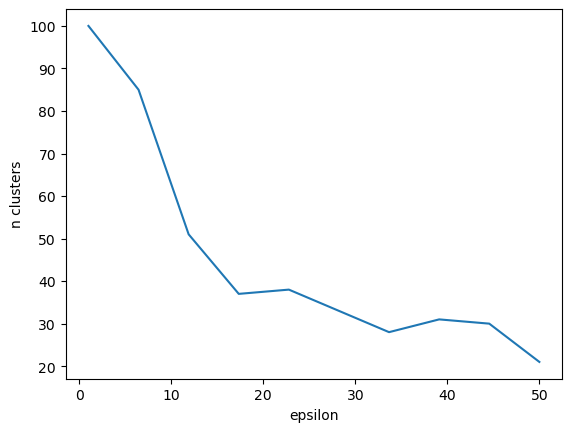

In [115]:
plt.plot(epsilons, nums)
plt.xlabel("epsilon")
plt.ylabel("n clusters")
plt.show()

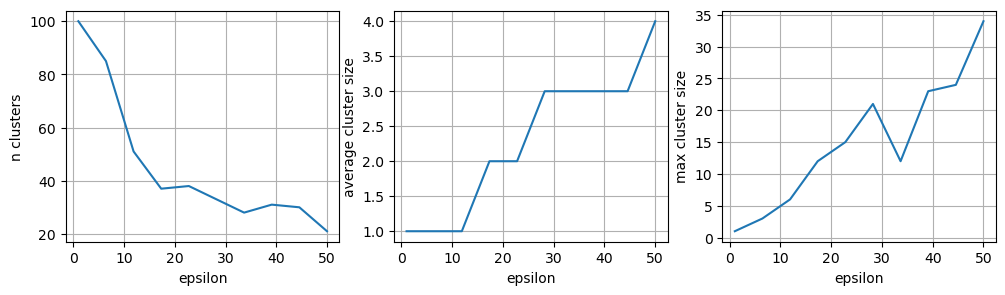

In [112]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))
axs[0].plot(epsilons, nums)
axs[2].plot(epsilons, max_sizes)
axs[1].plot(epsilons, av_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[2].set_ylabel('max cluster size')
axs[1].set_ylabel('average cluster size')
axs[2].set_xlabel('epsilon')
axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.show()

In [154]:
sizes.clear()
for i in range(len(R)):
    av_sizes = get_cluster_data(R[i])
    sizes.append(av_sizes)

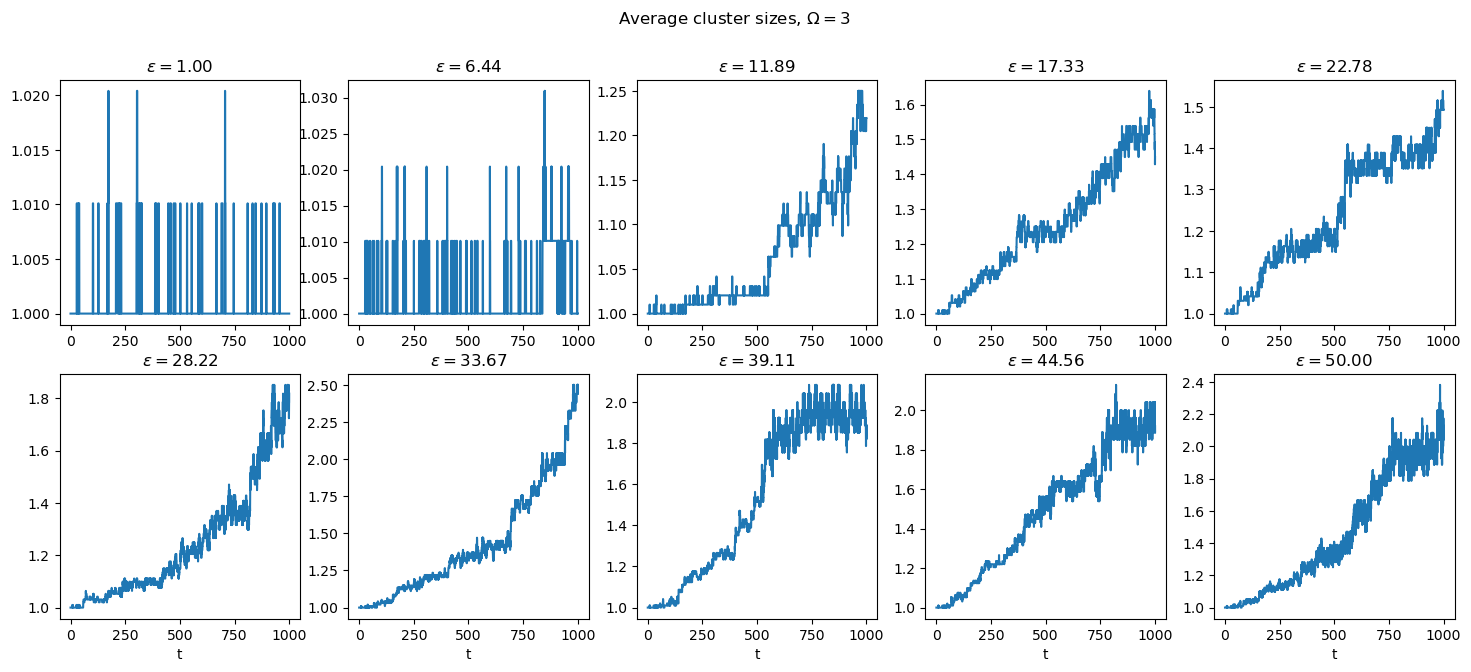

In [159]:
fig, axs = plt.subplots(2, 5, figsize = (18,7))
for i in range(len(epsilons)):
    axs[i // 5, i % 5].plot(t[::10], sizes[i])
    if i//5 != 0:
        axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
    axs[i // 5, i % 5].set_title(r'$\varepsilon = $'+f'{epsilons[i]:.2f}')
    
fig.suptitle(r'Average cluster sizes, $\Omega = 3$')
plt.show()

In [163]:
R.clear()
p.clear()
sizes.clear()
epsilons = np.linspace(1., 50., 10)
for i in range(len(epsilons)):
    print(i)
    ps, Rs, t = solver(1, epsilons[i], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    R.append(Rs)
    p.append(ps)
    sizes.append(get_cluster_data(Rs))

0
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
1
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
2
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
3
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
4
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
5
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
6
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
7
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
8
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614
9
Tumbling period: 642.0096170469793
omega/D_R: 306.60153746057614


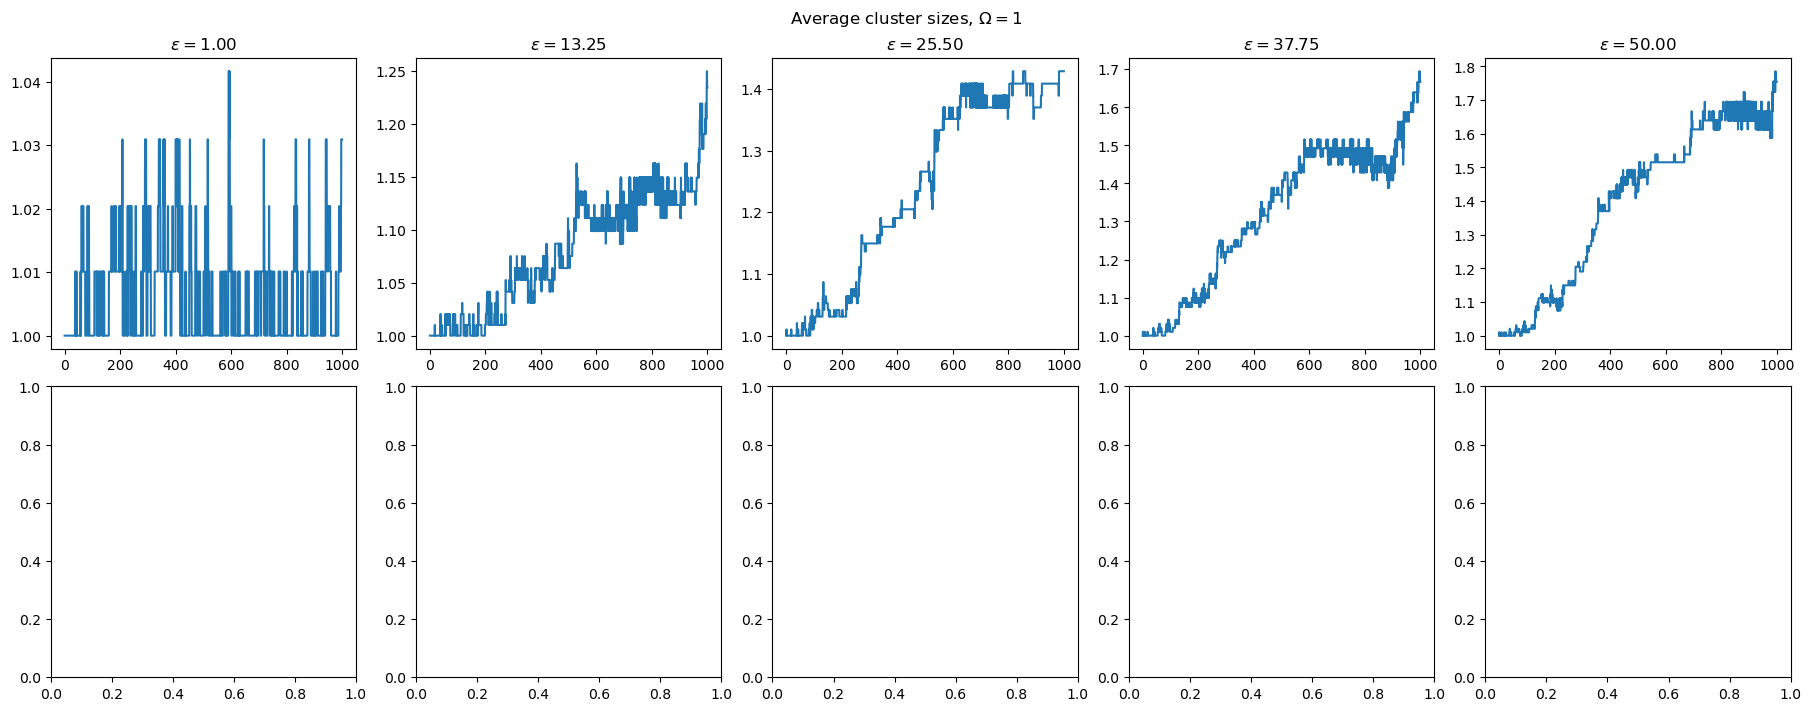

In [193]:
fig, axs = plt.subplots(2, 5, figsize = (18,7), layout = 'constrained')
for i in range(len(epsilons)):
    axs[i // 5, i % 5].plot(t[::10], sizes[i])
    if i//5 != 0:
        axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
    axs[i // 5, i % 5].set_title(r'$\varepsilon = $'+f'{epsilons[i]:.2f}')
    
fig.suptitle(r'Average cluster sizes, $\Omega = 1$')
plt.show()

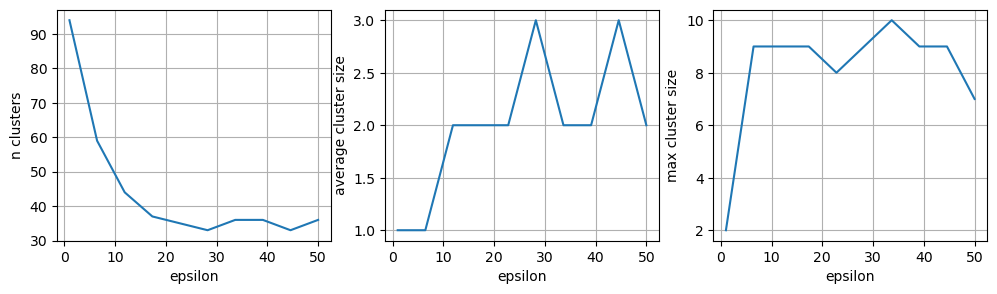

In [166]:
nums = []
max_sizes = []
av_sizes = []
for j in range(len(epsilons)):
    clust_num = 0
    clust_size = 0 
    clust_av_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(R[j][ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust) 
        clust_av_size += average_size(clust)
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    clust_av_size = clust_av_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)
    av_sizes.append(clust_av_size)

fig, axs = plt.subplots(1, 3, figsize = (12,3))
axs[0].plot(epsilons, nums)
axs[2].plot(epsilons, max_sizes)
axs[1].plot(epsilons, av_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[2].set_ylabel('max cluster size')
axs[1].set_ylabel('average cluster size')
axs[2].set_xlabel('epsilon')
axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.show()

In [195]:
np.meshgrid(epsilons, omegas)

(array([[ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ],
        [ 1.  , 13.25, 25.5 , 37.75, 50.  ]]),
 array([[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.9, 0.9, 0.9, 0.9, 0.9],
        [1.6, 1.6, 1.6, 1.6, 1.6],
        [2.3, 2.3, 2.3, 2.3, 2.3],
        [3. , 3. , 3. , 3. , 3. ]]))

In [54]:
epsilons = np.linspace(1., 50., 5)
omegas = np.linspace(0.2, 3., 5)
e, o = np.meshgrid(epsilons, omegas)
sizes_eo = np.empty((5, 5, 10000))
for i in range(5):
    for j in range(5):
        print(i, j)
        ps, Rs, t = solver(o[i, j], e[i, j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
        sizes_eo[i, j] = get_cluster_data(Rs)

0 0
No tumbling
omega/D_R: 61.32030749211523
0 1
No tumbling
omega/D_R: 61.32030749211523
0 2
No tumbling
omega/D_R: 61.32030749211523
0 3
No tumbling
omega/D_R: 61.32030749211523
0 4
No tumbling
omega/D_R: 61.32030749211523
1 0
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 1
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 2
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 3
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
1 4
Tumbling period: 718.866851545133
omega/D_R: 275.9413837145185
2 0
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 1
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 2
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 3
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
2 4
Tumbling period: 393.50857677898483
omega/D_R: 490.5624599369218
3 0
Tumbling period: 272.02973830254496
omega/D_R: 705.183536159325
3 1
Tumbling period: 272.02

<>:10: SyntaxWarning: invalid escape sequence '\O'
<>:10: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_9336/1471991046.py:10: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'


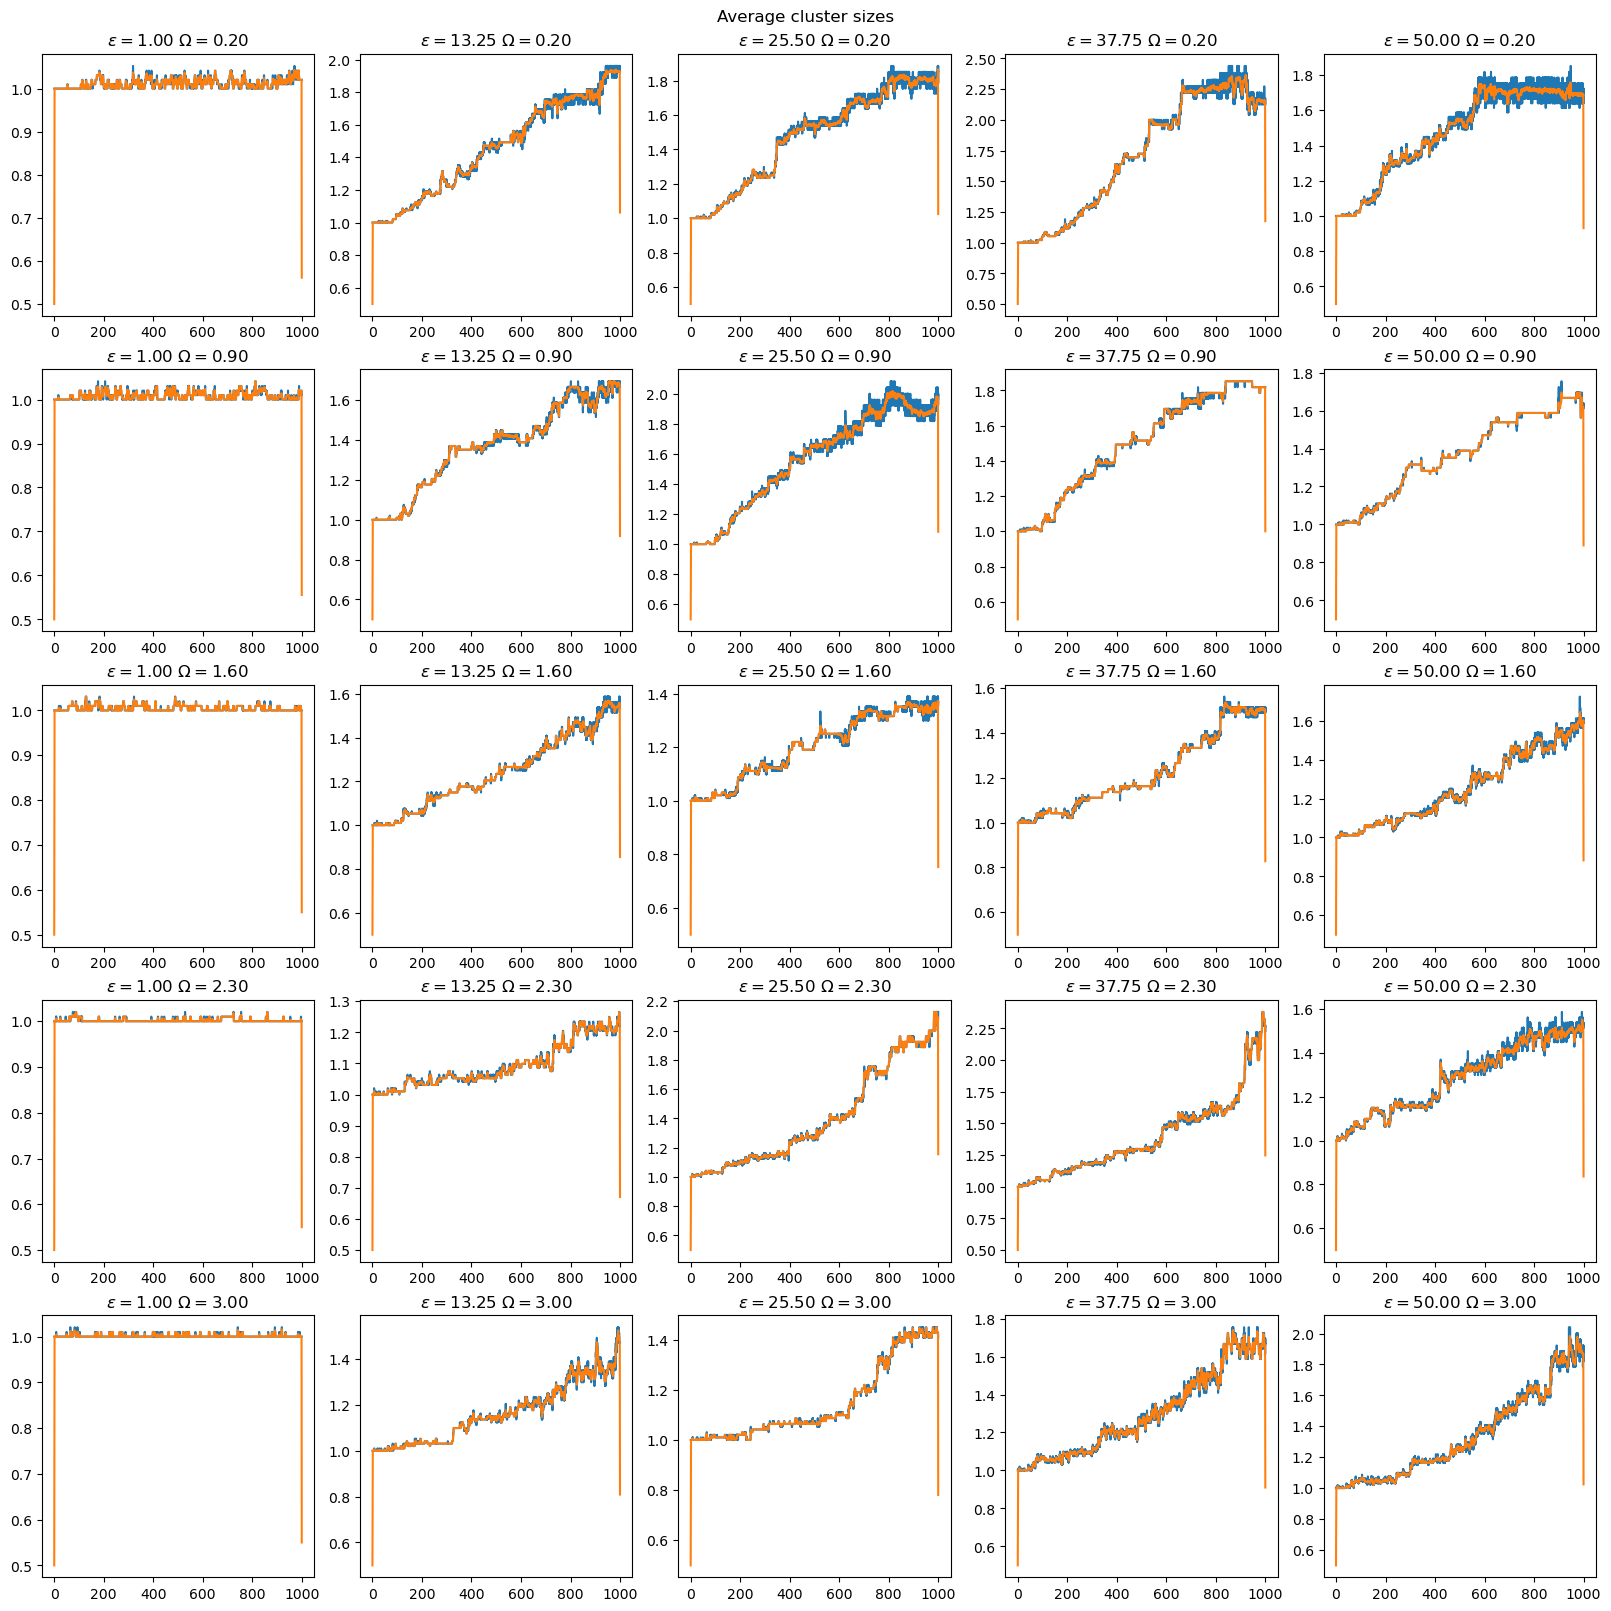

In [56]:
fig, axs = plt.subplots(5, 5, figsize = (16,16), layout = 'constrained')
for i in range(5):
    for j in range(5):
        axs[i, j].plot(t[::10], sizes_eo[i, j])
        moving_avg = np.convolve(sizes_eo[i, j], np.ones(window_size)/window_size, mode='same')
        axs[i, j].plot(t[::10], moving_avg)
    #if i//5 != 0:
        #axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
        title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'
        axs[i, j].set_title(title)
    
fig.suptitle(r'Average cluster sizes')
plt.show()

In [ ]:
epsilons = np.linspace(1., 50., 5)
omegas = np.linspace(0.2, 3., 5)
e, o = np.meshgrid(epsilons, omegas)
sizes_eo = np.empty((5, 5, 50000))
for i in range(5):
    for j in range(5):
        print(i, j)
        ps, Rs, t = solver(o[i, j], e[i, j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 500000, noise = True)
        sizes_eo[i, j] = get_cluster_data(Rs)

0 0
No tumbling
omega/D_R: 61.32030749211523
0 1
No tumbling
omega/D_R: 61.32030749211523


<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\O'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_9336/1757824251.py:11: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_9336/1757824251.py:11: SyntaxWarning: invalid escape sequence '\O'
  title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'


NameError: name 'sizes_eo' is not defined

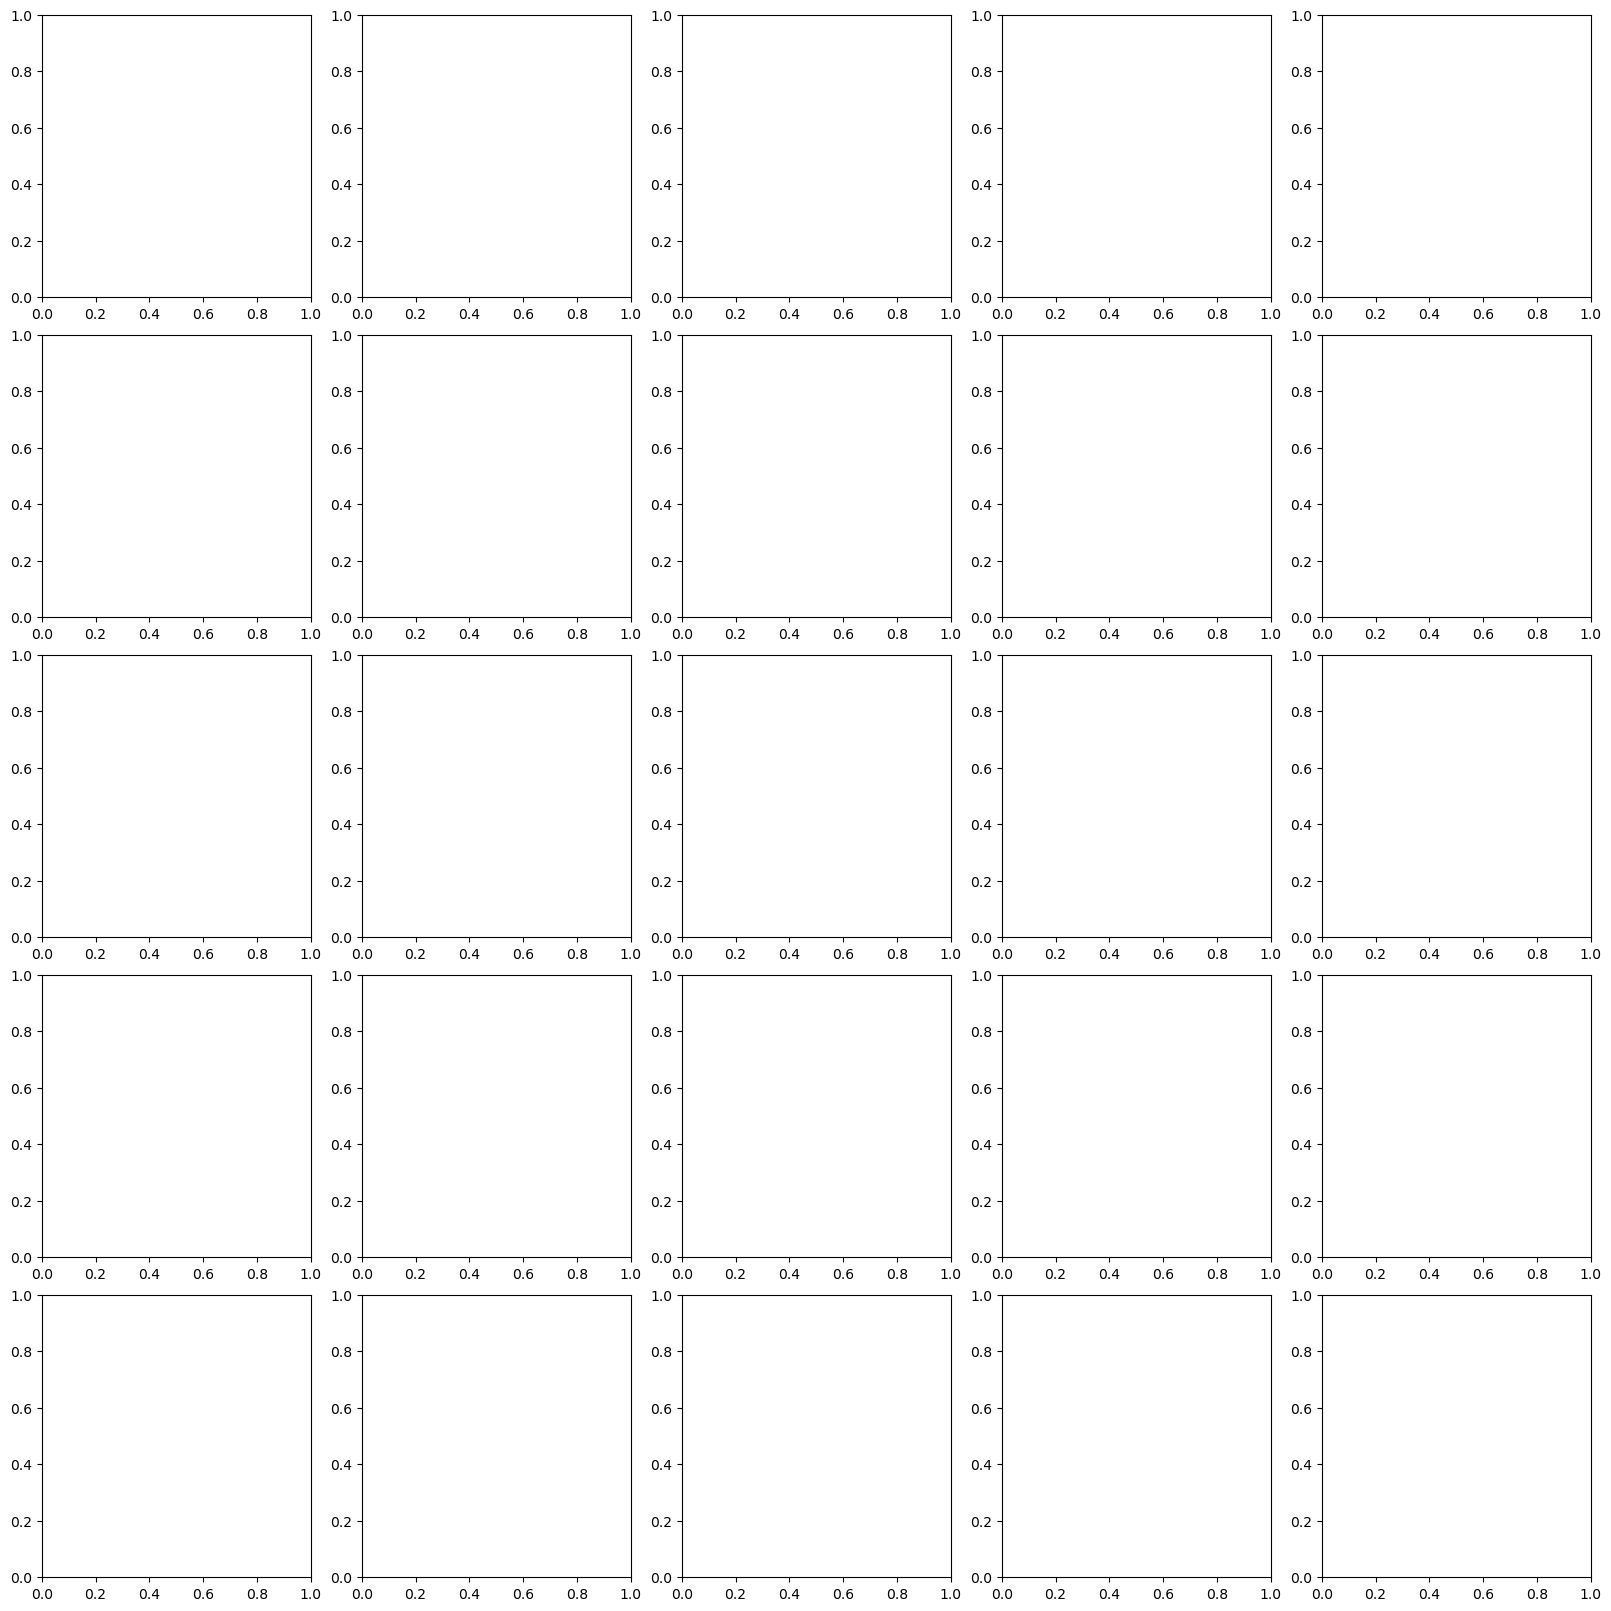

In [53]:
window_size = 20
fig, axs = plt.subplots(5, 5, figsize = (16,16), layout = 'constrained')
for i in range(5):
    for j in range(5):        
        axs[i, j].plot(t[::10], sizes_eo[i, j])
        moving_avg = np.convolve(sizes_eo[i, j], np.ones(window_size)/window_size, mode='same')
        axs[i, j].plot(t[::10], moving_avg)
    #if i//5 != 0:
        #axs[i // 5, i % 5].set_xlabel('t')
    #axs[i // 5, i % 5].set_ylabel('size')
        title = r'$\varepsilon = $'f'{e[i, j]:.2f} $\Omega = $'+f'{o[i, j]:.2f}'
        axs[i, j].set_title(title)
    
fig.suptitle(r'Average cluster sizes')
plt.show()

### $0<\varepsilon<100$

In [44]:
R.clear()
p.clear()
nums = []
max_sizes = []
nums.clear()
max_sizes.clear()
av_sizes.clear()
epsilons = np.linspace(1., 100., 20)
for j in range(len(epsilons)):
    print(j)
    ps, Rs, t = solver(3, epsilons[j], k0, euler, N, np.array(p0s), np.array(R0s), 0.01, 100000, noise = True)
    clust_num = 0
    clust_size = 0
    clust_av_size = 0
    for i in range(0, 100, 10):
        clust = np.sort(fclusterdata(Rs[ -1 - i, :, :], t=3, criterion='distance'))
        clust_num += clust[-1]
        clust_size += max_repetitions(clust)
        clust_av_size += average_size(clust)
    clust_av_size = clust_av_size / len(epsilons)
    clust_num = clust_num // len(epsilons)
    clust_size = clust_size // len(epsilons)
    nums.append(clust_num)
    max_sizes.append(clust_size)
    av_sizes.append(clust_av_size)

0
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
1
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
2
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
3
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
4
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
5
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
6
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
7
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
8
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
9
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
10
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
11
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
12
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
13
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
14
Tumbling period: 208.0543590107162
omega/D_R: 919.8046123817284
15
Tu

In [45]:
save_output(t, Rs, ps, N, 5, custom_name="epsilon100", skip = 100, num = 100000)

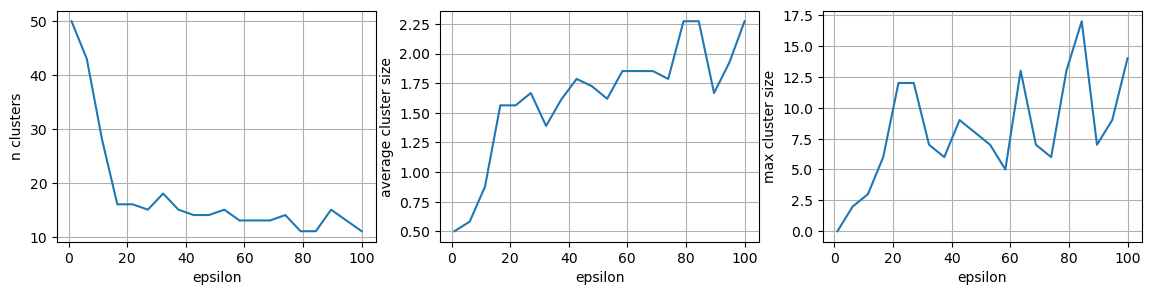

In [47]:
fig, axs = plt.subplots(1, 3, figsize = (14,3))
axs[0].plot(epsilons, nums)
axs[2].plot(epsilons, max_sizes)
axs[1].plot(epsilons, av_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[2].set_ylabel('max cluster size')
axs[1].set_ylabel('average cluster size')
axs[2].set_xlabel('epsilon')
axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.show()

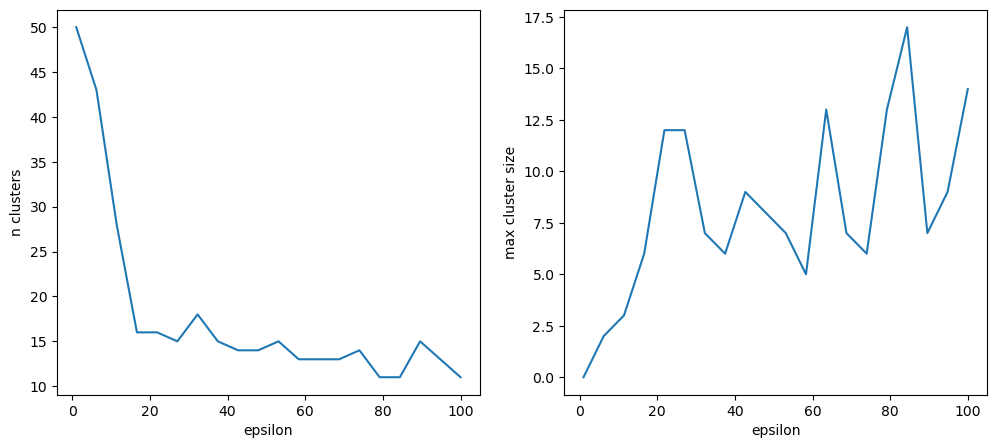

In [48]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(epsilons, nums)
axs[1].plot(epsilons, max_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[1].set_ylabel('max cluster size')

plt.show()

Other run:

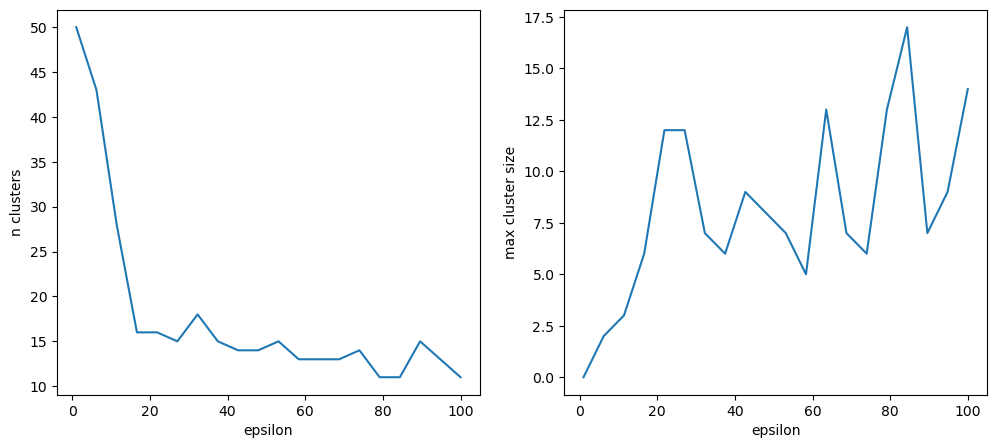

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (12,5))
axs[0].plot(epsilons, nums)
axs[1].plot(epsilons, max_sizes)
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('n clusters')
axs[1].set_xlabel('epsilon')
axs[1].set_ylabel('max cluster size')

plt.show()

## ?

/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_77527/1219468392.py:33: RuntimeWarning: divide by zero encountered in divide
  pg.transpose(), rg.transpose(), (xp/rg).transpose(), xr.transpose(),
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_77527/1219468392.py:33: RuntimeWarning: invalid value encountered in divide
  pg.transpose(), rg.transpose(), (xp/rg).transpose(), xr.transpose(),
/var/folders/p1/rd8wpshn4yn4t9rd0f432hdr0000gn/T/ipykernel_77527/1219468392.py:36: RuntimeWarning: divide by zero encountered in divide
  pg.transpose(), rg.transpose(), (yp/rg).transpose(), yr.transpose(),


(0.0, 1.0)

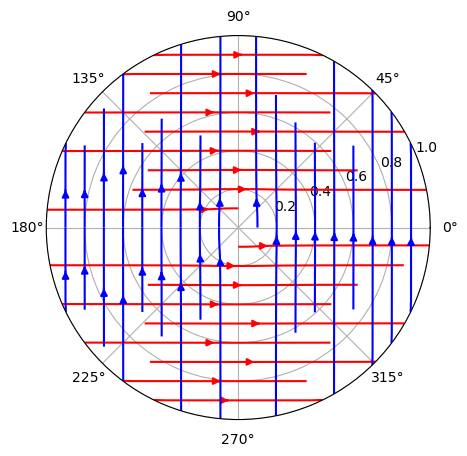

In [199]:
import math
plt.gcf().add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

# coordinates
r = np.linspace(0, 1, 11)
p = np.linspace(-math.pi, math.pi, 361)
rg, pg = np.meshgrid(r, p)

def repeat(x):
  return np.full_like(r, x)

epsilon = 1e-8

# cylindrical components of horizontal unit vector
xr =  np.cos(pg)
xp = -np.sin(pg)
# cylindrical components of vertical unit vector
yr =  np.sin(pg)
yp =  np.cos(pg)

# starting points of streamlines
sx = np.transpose([
  np.hstack([repeat(-math.pi/2), repeat(math.pi/2)]),
  np.hstack([r, r])
])
sy = np.transpose([
  np.hstack([repeat(-math.pi+epsilon), repeat(0), repeat(math.pi-epsilon)]),
  np.hstack([r, r, r])
])

# streamlines
plt.streamplot(
  pg.transpose(), rg.transpose(), (xp/rg).transpose(), xr.transpose(),
  color='red', start_points=sx)
plt.streamplot(
  pg.transpose(), rg.transpose(), (yp/rg).transpose(), yr.transpose(),
  color='blue', start_points=sy)

plt.ylim(0, 1)


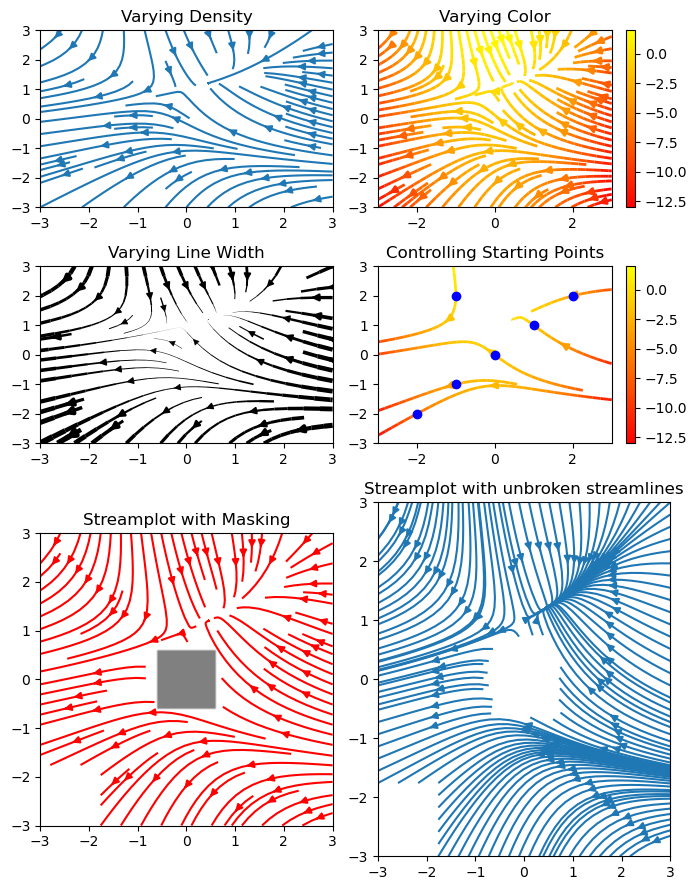

In [200]:
import matplotlib.pyplot as plt
import numpy as np

w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig, axs = plt.subplots(3, 2, figsize=(7, 9), height_ratios=[1, 1, 2])
axs = axs.flat

#  Varying density along a streamline
axs[0].streamplot(X, Y, U, V, density=[0.5, 1])
axs[0].set_title('Varying Density')

# Varying color along a streamline
strm = axs[1].streamplot(X, Y, U, V, color=U, linewidth=2, cmap='autumn')
fig.colorbar(strm.lines)
axs[1].set_title('Varying Color')

#  Varying line width along a streamline
lw = 5*speed / speed.max()
axs[2].streamplot(X, Y, U, V, density=0.6, color='k', linewidth=lw)
axs[2].set_title('Varying Line Width')

# Controlling the starting points of the streamlines
seed_points = np.array([[-2, -1, 0, 1, 2, -1], [-2, -1,  0, 1, 2, 2]])

strm = axs[3].streamplot(X, Y, U, V, color=U, linewidth=2,
                         cmap='autumn', start_points=seed_points.T)
fig.colorbar(strm.lines)
axs[3].set_title('Controlling Starting Points')

# Displaying the starting points with blue symbols.
axs[3].plot(seed_points[0], seed_points[1], 'bo')
axs[3].set(xlim=(-w, w), ylim=(-w, w))

# Create a mask
mask = np.zeros(U.shape, dtype=bool)
mask[40:60, 40:60] = True
U[:20, :20] = np.nan
U = np.ma.array(U, mask=mask)

axs[4].streamplot(X, Y, U, V, color='r')
axs[4].set_title('Streamplot with Masking')

axs[4].imshow(~mask, extent=(-w, w, -w, w), alpha=0.5, cmap='gray',
              aspect='auto')
axs[4].set_aspect('equal')

axs[5].streamplot(X, Y, U, V, broken_streamlines=False)
axs[5].set_title('Streamplot with unbroken streamlines')

plt.tight_layout()
plt.show()